# Hydraulic modelling in water distribution networks
### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London\
Summer 2023

Prepared by Bradley Jenks, Yuanyang Liu, and Ivan Stoianov

### Preamble
This notebook walks through code implementation for developing a hydraulic solver to model water distribution networks (WDNs). Specifically, we cover the following items:
- Using the WNTR Python package for WDN analysis
- System of mass and energy conservation equations
- Newton-Raphson method for solving system of nonlinear equations
- Block factorisation and the Schur complement 
- Application of hydraulic solver on different case networks
- Remarks on computational performance

First, we must change to the project's base directory (only run this once).

In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/bradw/workspace/CIVE_70019_70057'

### WNTR Python package

The Water Network Tool for Resilience (WNTR) Python package for simulating WDNs. It is based on the EPANET solvers. Here, we will be using WNTR to load network data (.inp file) and compare hydraulic simulation results with our own solver.

#### Using WNTR's hydraulic solver
The code below follows an example from WNTR's documentation: https://wntr.readthedocs.io/en/latest/index.html. Note that we have uploaded four (4) network (.inp) files for use in this notebook.

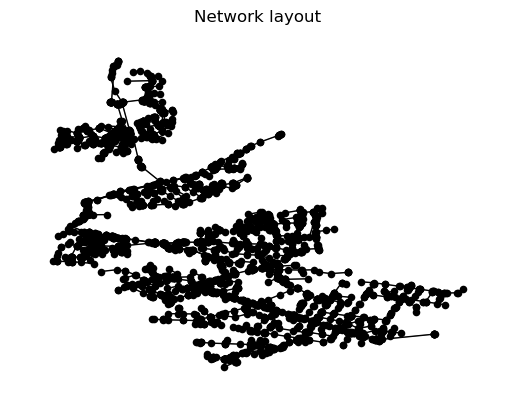

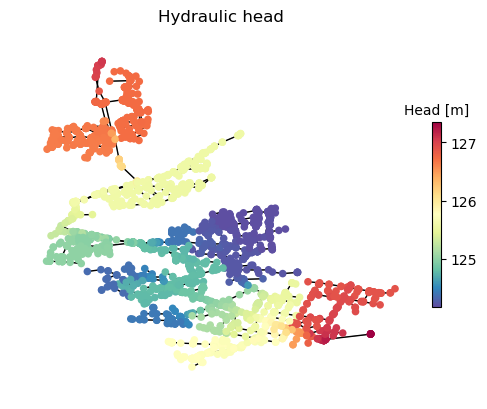

In [2]:
# Load dependencies
import wntr

# net_name = 'demo.inp'
# net_name = 'pescara.inp'
# net_name = 'BWSnet.inp'
net_name = 'bwfl_2022_05_hw.inp'

# Create water network model
net_dir = os.path.join(os.getcwd(), 'data/networks/')
wn = wntr.network.WaterNetworkModel(os.path.join(net_dir, net_name))

# Graph the network
wntr.graphics.plot_network(wn, title='Network layout', node_size=30)

# Simulate hydraulics
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
hydraulic_state = 'head' # or 'flow' or 'head'

if hydraulic_state == 'head':
    head = results.node['head'].loc[0, :]
    wntr.graphics.plot_network(wn, node_attribute=head, 
                            title='Hydraulic head', node_colorbar_label='Head [m]', node_size=30)
elif hydraulic_state == 'pressure':
    pressure = results.node['pressure'].loc[0, :]
    wntr.graphics.plot_network(wn, node_attribute=pressure, 
                            title='Pressure head', node_colorbar_label='Pressure [m]', node_size=30)
elif hydraulic_state == 'flow':
    flow = results.link['flowrate'].loc[0, :]
    wntr.graphics.plot_network(wn, link_attribute=flow, 
                            title='Link flow', link_colorbar_label='Flow [L/s]', node_size=0)

#### Data extraction
We will now use WNTR to extract network data for developing our own hydraulic solver.

In [3]:
# Load additional dependencies
import networkx as nx
import pandas as pd
import numpy as np
import scipy.sparse as sp

Get network elements and simulation information.

In [4]:
'''
    nt = number of discrete time steps
    nn = number of demand or junction nodes
    np = number of links
    n0 = number of source (reservoir) nodes
'''

nt = int(wn.options.time.duration / wn.options.time.hydraulic_timestep)
nt = nt if nt>0 else 1
net_info = dict(
    np=wn.num_links,
    nn=wn.num_junctions,
    n0=wn.num_reservoirs,
    nt=nt,
    headloss=wn.options.hydraulic.headloss,
    units=wn.options.hydraulic.inpfile_units,
    reservoir_names=wn.reservoir_name_list,
    junction_names=wn.junction_name_list,
    pipe_names=wn.pipe_name_list,
    valve_names=wn.valve_name_list,
    prv_names=wn.prv_name_list
)

Extract link data.

In [5]:
# Check head loss model
if net_info['headloss'] == 'H-W':
    n_exp = 1.852
elif net_info['headloss'] == 'D-W':
    n_exp = 2

# NB: 'C' denotes roughness or HW coefficient for pipes and local (minor) loss coefficient for valves
link_df = pd.DataFrame(
    index=pd.RangeIndex(net_info['np']),
    columns=['link_ID', 'link_type', 'diameter', 'length', 'n_exp', 'C', 'node_out', 'node_in'],
)
def link_dict(link):
    if isinstance(link, wntr.network.Pipe):  # check if the link is a pipe
        return dict(
            link_ID=link.name,
            link_type='pipe',
            diameter=link.diameter,
            length=link.length,
            n_exp=n_exp,
            C=link.roughness,
            node_out=link.start_node_name,
            node_in=link.end_node_name
        )
    elif isinstance(link, wntr.network.Valve): # check if the link is a valve
        return dict(
            link_ID=link.name,
            link_type='valve',
            diameter=link.diameter,
            length=2*link.diameter,
            n_exp=2,
            C=link.minor_loss,
            node_out=link.start_node_name,
            node_in=link.end_node_name
        )
    
for idx, link in enumerate(wn.links()):
    link_df.loc[idx] = link_dict(link[1])
 
link_df

,link_ID,link_type,diameter,length,n_exp,C,node_out,node_in
0,link_0001,pipe,0.1016,8.09,1.852,125.654067,node_0001,node_0844
1,link_0002,pipe,0.1016,2.41,1.852,107.192561,node_0002,node_0359
2,link_0003,pipe,0.0965,1.33,1.852,127.561943,node_0003,node_0870
3,link_0004,pipe,0.1524,2.51,1.852,118.387304,node_0004,node_0524
4,link_0005,pipe,0.1016,24.0,1.852,127.561943,node_0006,node_2362
...,...,...,...,...,...,...,...,...
2811,link_2813,valve,0.08,0.16,2,0.0001,node_1942,node_1943
2812,link_2814,valve,0.08,0.16,2,0.0001,node_1944,node_1945
2813,link_2815,valve,0.1,0.2,2,0.0001,node_1946,node_1947
2814,link_2816,valve,0.08,0.16,2,0.0001,node_1948,node_1949


Extract node data.

In [6]:
node_df = pd.DataFrame(
    index=pd.RangeIndex(wn.num_nodes), columns=["node_ID", "elev", "xcoord", "ycoord"]
)

def node_dict(node):
    if isinstance(node, wntr.network.elements.Reservoir):
        elev = 0
    else:
        elev = node.elevation
    return dict(
        node_ID=node.name,
        elev=elev,
        xcoord=node.coordinates[0],
        ycoord=node.coordinates[1]
    )

for idx, node in enumerate(wn.nodes()):
    node_df.loc[idx] = node_dict(node[1])
    
node_df

,node_ID,elev,xcoord,ycoord
0,node_0001,27.965236,362017.8,176267.7
1,node_0002,48.2573,362386.3,175503.8
2,node_0003,51.559723,362329.7,176010.5
3,node_0004,44.545853,362116.2,176116.21
4,node_0005,39.001898,362144.12,176246.35
...,...,...,...,...
2742,node_2743,48.86,363004.35,175867.82
2743,node_2744,62.4,363269.45,175552.41
2744,node_2745,44.73,362252.25,176209.79
2745,node_2746,0,362328.65,178605.55


Create network graph.

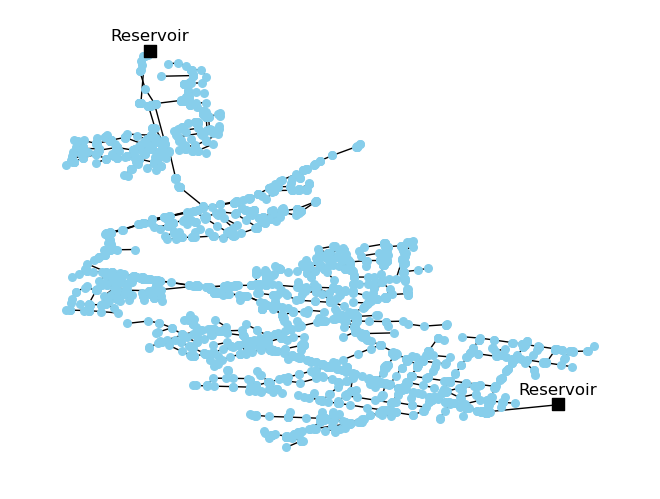

In [7]:
# extract network as a graph
# G = wn.to_graph()
# uG = G.to_undirected() # change to undirected graph structure
uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
        
# draw entire network
nx.draw(uG, pos, node_size=30, node_shape='o', node_color='skyblue')
# draw reservoir nodes
nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=75, node_shape='s', node_color='black')
# reservoir labels
labels = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='bottom')
for _, label in labels.items():
    label.set_y(label.get_position()[1] + 80)


# create adjacency matrices
A = np.zeros((net_info['np'], net_info['nn']+net_info['n0']), dtype=int)
for k, row in link_df.iterrows():
    # find start node
    out_name = row['node_out']
    out_idx = node_df[node_df['node_ID']==out_name].index[0]
    # find end node
    in_name = row['node_in']
    in_idx = node_df[node_df['node_ID']==in_name].index[0]
    
    A[k, out_idx] = -1
    A[k, in_idx] = 1
    
junction_idx = node_df.index[node_df['node_ID'].isin(net_info['junction_names'])].tolist()
reservoir_idx = node_df.index[node_df['node_ID'].isin(net_info['reservoir_names'])].tolist()

# incident matrices
A12 = A[:, junction_idx]; A12 = sp.csr_matrix(A12) # link-junction incident matrix
A10 = A[:, reservoir_idx]; A10 = sp.csr_matrix(A10) # link-reservoir indicent matrix

Extract operational data (e.g. demands, boundary heads).

In [8]:
# demand data
demand_df = results.node['demand'].T
col_names = [f'demands_{t}' for t in range(1, len(demand_df.columns)+1)]
demand_df.columns = col_names
demand_df.reset_index(drop=False, inplace=True)
demand_df = demand_df.rename(columns={'name': 'node_ID'})

if net_info['nt'] > 1:
    demand_df = demand_df.iloc[:, :-1] # delete last time step
    
demand_df = demand_df[~demand_df['node_ID'].isin(net_info['reservoir_names'])] # delete reservoir nodes
demand_df

,node_ID,demands_1,demands_2,demands_3,demands_4,demands_5,demands_6,demands_7,demands_8,demands_9,...,demands_87,demands_88,demands_89,demands_90,demands_91,demands_92,demands_93,demands_94,demands_95,demands_96
0,node_0001,0.000011,0.000010,0.000010,0.000010,0.000009,0.000008,0.000008,0.000007,0.000007,...,0.000019,0.000018,0.000017,0.000017,0.000017,0.000016,0.000016,0.000015,0.000014,0.000013
1,node_0002,0.000015,0.000013,0.000012,0.000011,0.000011,0.000010,0.000010,0.000010,0.000009,...,0.000022,0.000022,0.000021,0.000020,0.000019,0.000018,0.000018,0.000017,0.000016,0.000016
2,node_0003,0.000006,0.000006,0.000006,0.000006,0.000006,0.000005,0.000005,0.000005,0.000005,...,0.000009,0.000009,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000007,0.000007
3,node_0004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
4,node_0005,0.000019,0.000016,0.000016,0.000016,0.000015,0.000013,0.000012,0.000011,0.000010,...,0.000035,0.000033,0.000031,0.000031,0.000030,0.000029,0.000028,0.000027,0.000025,0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,node_2741,0.000012,0.000011,0.000010,0.000010,0.000010,0.000009,0.000009,0.000009,0.000009,...,0.000017,0.000017,0.000017,0.000016,0.000015,0.000015,0.000014,0.000014,0.000013,0.000013
2741,node_2742,0.000045,0.000037,0.000030,0.000026,0.000023,0.000022,0.000022,0.000019,0.000017,...,0.000080,0.000080,0.000077,0.000072,0.000068,0.000062,0.000059,0.000055,0.000052,0.000051
2742,node_2743,0.000209,0.000166,0.000132,0.000110,0.000094,0.000087,0.000086,0.000072,0.000058,...,0.000401,0.000399,0.000384,0.000354,0.000334,0.000304,0.000289,0.000265,0.000248,0.000240
2743,node_2744,0.000024,0.000020,0.000019,0.000019,0.000018,0.000016,0.000014,0.000013,0.000012,...,0.000045,0.000042,0.000039,0.000039,0.000038,0.000036,0.000035,0.000034,0.000032,0.000028


In [9]:
# boundary head data
h0_df = results.node['head'].T
col_names = [f'h0_{t}' for t in range(1, len(h0_df.columns)+1)]
h0_df.columns = col_names
h0_df.reset_index(drop=False, inplace=True)
h0_df = h0_df.rename(columns={'name': 'node_ID'})

if net_info['nt'] > 1:
    h0_df = h0_df.iloc[:, :-1] # delete last time step
    
h0_df = h0_df[h0_df['node_ID'].isin(net_info['reservoir_names'])] # only reservoir nodes
h0_df

,node_ID,h0_1,h0_2,h0_3,h0_4,h0_5,h0_6,h0_7,h0_8,h0_9,...,h0_87,h0_88,h0_89,h0_90,h0_91,h0_92,h0_93,h0_94,h0_95,h0_96
2745,node_2746,127.054893,127.550903,127.913994,128.036392,127.629501,125.011505,123.488899,123.747894,124.288803,...,124.798103,125.158600,124.878204,124.843498,124.065300,122.950600,121.028503,121.234200,121.960999,123.270195
2746,node_2747,127.350304,129.744598,129.981796,129.240402,127.944603,126.162399,125.321800,124.516800,124.782997,...,124.536499,125.741997,125.233398,125.446297,125.465805,124.435608,123.584801,125.887199,126.285904,126.708397


<span style="color:red">**NB: The above code comprise functions 'load_network_data' and 'plot_network' in the file '~/src/functions.py'**.</span>

### Newton-Raphson hydraulic solver
We will now develop our own hydraulic solver using the Newton-Raphson method for solving nonlinear systems of equations. 

#### System of nonlinear equations
Hydraulic states are computed for each time step $t \in \{1, \dots, n_t\}$, where $n_t$ denotes the number of discrete time steps in the simulation period. These comprise the following unknown variables for which we wish to solve:
- Flow rate $q_t \in \mathbb{R}^{n_p}$ conveyed across network links, where $n_p$ is the number of links
- Hydraulic head $h_t \in \mathbb{R}^{n_n}$ at network nodes, where $n_n$ is the number of junction nodes

Their solution is governed by **energy** and **mass** conservation equations, as follows:

\begin{equation}
    A_{11}(q_t)q_t + A_{12}h_t + A_{10}h_{0t} = 0 \\
    A_{12}^{T}q_t + d_t = 0,
\label{eq:hydraulic} \tag{1}
\end{equation}

where
- $A_{11} \in \mathbb{R}^{n_p \times n_p} = k_j|q_j^{n-1}|, \;\, \forall j \in \{1, \dots, n_p\}$ is a diagonal matrix of frictional head losses and $k_j$ is the pipe or valve resistance coefficient
- $A_{12} \in \mathbb{R}^{n_p \times n_n}$ is the link-node incidence matrix
- $A_{10} \in \mathbb{R}^{n_p \times n_0}$ is the link-known head incidence matrix
- $d_t \in \mathbb{R}^{n_n}$ is the vector of known demands (i.e. loading conditions)
- $h_{0t} \in \mathbb{R}^{n_0}$ is the vector of known hydraulic heads (i.e. boundary conditions)

Since the same equations are applied for all time steps, we omit the index $t$ henceforth. The system of nonlinear equations in \eqref{eq:hydraulic} is written in matrix form, as follows:

\begin{equation}
 F(q,h):= \left[
    {\renewcommand{\arraystretch}{1.5}
        \begin{array}{cc}
            A_{11}(q) & A_{12}  \\
            A_{12}^{T} & 0 \\ 
        \end{array}}\right]
    \left[
    {\renewcommand{\arraystretch}{1.5}
        \begin{array}{c}
            q \\
            h \\
        \end{array}}\right] -
    \left[
    {\renewcommand{\arraystretch}{1.5}
        \begin{array}{c}
            -A_{10}h_0 \\
            d \\ 
        \end{array}}\right] = 0.
\label{eq:hydraulic_matrix} \tag{2}
\end{equation}

#### Newton-Raphson method
We can then apply the Newton-Raphson method to solve the system of nonlinear equations in \eqref{eq:hydraulic_matrix}. The Newton-Raphson method is an iterative numerical technique for finding the root of an equation. At each iteration $k$, a new estimate of the root is found using the following formula: 

\begin{equation}
    x^{k+1} = x^k - J(x^k)^{-1}F(x^k),
\label{eq:newton_raphson_1} \tag{3}
\end{equation}

where $J(x)$ is the Jacobian, a matrix of first-order partial derivatives. In general form, if $F(x)$ has $m$ equations, $f_1,f_2,\dots,f_m$, and $n$ variables, $x_1,x_2,\dots,x_n$, as

\begin{equation}
    F(x)= \left[\begin{array}{c}
    f_1(x_1,\cdot,x_n)\\
    \vdots\\
    f_m(x_1,\cdot,x_n)\\
    \end{array}\right],
\label{eq:general_function} \tag{4}
\end{equation}

then the Jacobian $J(x)$ is expressed mathematically as follows:

\begin{equation}
    J(x) =\left[\begin{array}{cccc}
    \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \cdots & \frac{\partial f_1}{\partial x_n}\\
    \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \cdots & \frac{\partial f_2}{\partial x_n}\\
    \vdots & \vdots & \ddots & \vdots\\
    \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} & \cdots & \frac{\partial f_m}{\partial x_n}\\
    \end{array}\right].
\label{eq:jacobian} \tag{5}
\end{equation}

#### Hydraulic solver
We now define the Jacobian $J(x)$ and Newton-Raphson steps to compute a unique solution to the hydraulic model in \eqref{eq:hydraulic}. The system of nonlinear equations, 

\begin{equation}
F(q, h) := \left\lbrace \begin{array}{ll}
    f_1(q,h) = A_{11}(q)q + A_{12}h + A_{10}h_0 = 0 \\
    f_2(q,h) = A_{21}q - d = 0,
\end{array}\right.
\label{eq:nonlinear_system} \tag{6}
\end{equation}

has a Jacobian computed as

\begin{equation}
J (q, h) := \left\lbrace \begin{array}{ll}
    \frac{\partial f_1 }{\partial q}=\frac{\partial A_{11}(q)q}{\partial q}=\frac{\partial K|q^{n-1}|q}{\partial q}={N Kq}^{n-1} ={NA_{11}(q)} \\
    \frac{\partial f_1 }{\partial h}=\frac{\partial A_{12} h}{\partial h}=A_{12} \\
    \frac{\partial f_2 }{\partial q}=\frac{\partial A_{12}^T q}{\partial q}=A_{12}^T \\
    \frac{\partial f_2 }{\partial h}=0, 
\end{array}\right.
\label{eq:jacobian_hydraulic} \tag{7}
\end{equation}

which can be written in matrix form as

\begin{equation}
    J(q,h)=\left[\begin{array}{cc}
    \frac{\partial f_1}{\partial q} & \frac{\partial f_1}{\partial h} \\
    \frac{\partial f_2}{\partial q} & \frac{\partial f_2}{\partial h} \\
    \end{array}\right]=\left[\begin{array}{cc}
    NA_{11}(q) & {A_{12}} \\
    {A_{12}^T} & 0 \\
    \end{array}\right], \; \text{where} \;
    N=\left[\begin{array}{cccc}
        n & 0 & \cdots & 0 \\
        0 & n & \cdots & 0 \\
        \vdots & \vdots & \ddots & 0 \\
        0 & 0 & \cdots & n \\
    \end{array}\right].
\label{eq:jacobian_hydraulic_matrix} \tag{8}
\end{equation}

However, computing the inverse of the Jacobian is not computationally efficient (at every iteration) and it may not be possible for singular matrices (i.e. zero-flow pipes). We therefore multiply both sides of \eqref{eq:newton_raphson_1} by $J(x^k)$ to eliminate its inverse:

\begin{equation}
    J(x^k)x^{k+1}=J(x^k)x^k-F(x^k).
\label{eq:newton_raphson_2} \tag{9}
\end{equation}

Each new iterate $x_{k+1}$ of the Newton-Raphson equation is computed by solving the following linear system:

\begin{equation}
    \left[\begin{array}{cc}
         NA_{11}(h_k)& A_{12} \\
         A_{12}^T& 0 \\
    \end{array}\right] 
    \left[\begin{array}{c}
         q^{k+1} \\
         h^{k+1} \\
    \end{array}\right] = 
    \left[\begin{array}{cc}
         NA_{11}(q^{k})& A_{12}  \\
         A_{12}^T& 0 \\
    \end{array}\right] 
    \left[\begin{array}{c}
         q^{k} \\
         h^{k} \\
    \end{array}\right] - \left[\left[\begin{array}{cc}
         A_{11}(q^{k})& A_{12} \\
         A_{12}^T& 0\\
    \end{array}\right] 
    \left[\begin{array}{c}
         q^{k} \\
         h^{k} \\
    \end{array}\right]+\left[\begin{array}{c}
         A_{10}h_0 \\
         -d\\
    \end{array}\right]\right],
\label{eq:newton_step_1} \tag{10}
\end{equation}

which simplifies to,

\begin{equation}
    \left[\begin{array}{cc}
         NA_{11}(q^k)& A_{12} \\
         A_{12}^T & 0\\
    \end{array}\right] \left[\begin{array}{c}
          q^{k+1} \\
          h^{k+1} \\
    \end{array}\right]=
    \left[\begin{array}{c}
         (N-I)A_{11}(q^k)q^k-A_{10}h_0\\
         d\\ 
    \end{array}\right].
\label{eq:newton_step_2} \tag{11}
\end{equation}

At each iteration $k$, we perform the following convergence check:

\begin{equation}
\begin{Vmatrix} 
        A_{11}(q^{k+1})q^{k+1} + A_{12}h^{k+1} + A_{10}h_0 \\
        A_{12}^Tq^{k+1} - d
\end{Vmatrix}
    _{\infty} < \epsilon_{\text{tol}}
\label{eq:convergence_check} \tag{12}
\end{equation}

where the solver has converged if the maximum error is less than a specified tolerance $\epsilon_{\text{tol}}$. The solution process for using the Newton-Raphson method for solving the system of nonlinear equations is shown in the figure below.

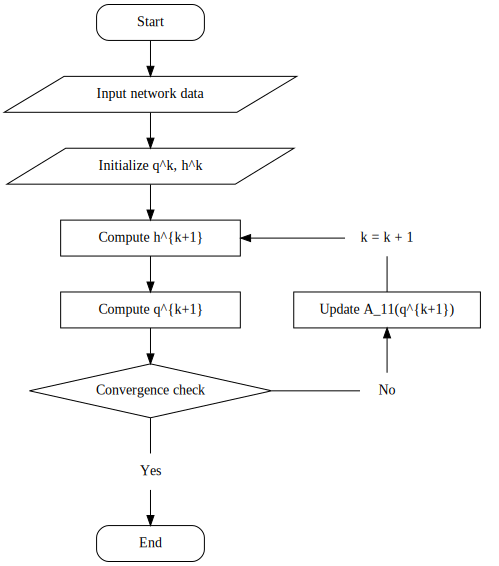

In [10]:
# code for generating solution process chart
from graphviz import Digraph

dot = Digraph()

# Add nodes
dot.node("start", label="Start", shape="rect", width="1.5", height="0.5", style="rounded")
dot.node("input", label="Input network data", shape="parallelogram")
dot.node("initial", label="Initialize q^k, h^k", shape="parallelogram")
dot.node("end", label="End", shape="rect", width="1.5", height="0.5", style="rounded")
dot.node("convergence", label="Convergence check", shape="diamond", width="1.0", height="0.75")
dot.node("compute_h", label="Compute h^{k+1}", shape="rect", width="2.5")
dot.node("compute_q", label="Compute q^{k+1}", shape="rect", width="2.5")
dot.node("update", label="Update A_11(q^{k+1})", shape="rect")
dot.node("convergence", label="Convergence check", shape="diamond", width="1.0", height="0.75")
dot.node("dummy_1", label="No", shape="plaintext", width="0.75", height="0.5")
dot.node("dummy_2", label="k = k + 1", shape="plaintext", width="0.75", height="0.5")
dot.node("dummy_3", label="Yes", shape="plaintext", width="0.75", height="0.5")

# Add edges
dot.edge("start", "input")
dot.edge("input", "initial")
dot.edge("convergence", "dummy_3", dir="none")
dot.edge("dummy_3", "end")
dot.edge("initial", "compute_h")
dot.edge("compute_h", "compute_q", headport="n", tailport="s")
dot.edge("compute_q", "convergence", headport="n", tailport="s")
dot.edge("dummy_1", "update", headport="s")
dot.edge("dummy_2", "update", dir="none", headport="n")

# Subgraphs
with dot.subgraph(name="same_level_1") as s1:
    s1.attr(rank="same")
    s1.edge("compute_q", "update", style="invis", minlen="3")
with dot.subgraph(name="same_level_2") as s2:
    s2.attr(rank="same")
    s2.edge("convergence", "dummy_1", dir="none")
with dot.subgraph(name="same_level_3") as s3:
    s3.attr(rank="same")
    s3.edge("compute_h", "dummy_2", dir="back", minlen="2")
with dot.subgraph(name="same_level_4") as s4:
    s4.attr(rankdir="TB")
    s4.edge("dummy_1", "dummy_2", style="invis")
with dot.subgraph(name="same_level_5") as s5:
    s5.attr(rank="TB")
    s5.edge("compute_h", "compute_q", style="invis")
    s5.edge("compute_q", "convergence", style="invis")

# View flowchart
dot

Below is code for implementing the Newton-Raphson solver described above.

In [11]:
from src import functions as fn

First, we use previously written code (now in a function) to load network data.

In [12]:
# net_name = 'demo.inp'
# net_name = 'pescara.inp'
# net_name = 'BWSnet.inp'
net_name = 'bwfl_2022_05_hw.inp'

net_dir = os.path.join(os.getcwd(), 'data/networks/', net_name)
wdn = fn.load_network_data(net_dir)

The network layout is plotted below.

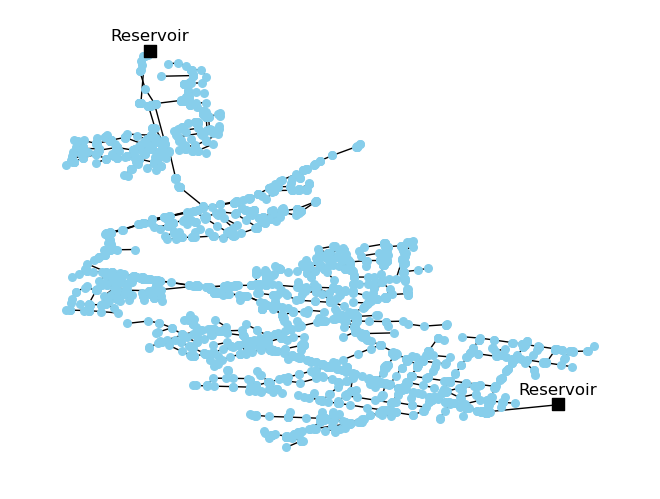

In [13]:
fn.plot_network(wdn)

Code for the Newton-Raphson solver is below.

In [14]:
### Step 1: unload network and hydraulic data
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df
h0_df = wdn.h0_df

# define head loss equations
def friction_loss(net_info, df):
    if net_info['headloss'] == 'H-W':
        K = 10.67 * df['length'] * (df['C'] ** -df['n_exp']) * (df['diameter'] ** -4.8704)
    else:
        K = [] # insert DW formula here...
    
    return K

def local_loss(df):
    K = (8 / (np.pi ** 2 * 9.81)) * (df['diameter'] ** -4) * df['C']
    
    return K

# compute loss coefficients
K = np.zeros((net_info['np'], 1))
for idx, row in link_df.iterrows():
    if row['link_type'] == 'pipe':
        K[idx] = friction_loss(net_info, row)

    elif row['link_type'] == 'valve':
        K[idx] = local_loss(row)
        
n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    
# set stopping criteria
tol = 1e-5
kmax = 50 

# small values in A11 make convergence unsteady; therefore, we need to define a lower bound -- see Todini (1988), page 7
tol_A11 = 1e-5

# set solution arrays
q = np.zeros((net_info['np'], net_info['nt']))
h = np.zeros((net_info['nn'], net_info['nt']))


# run over all time steps
for t in range(net_info['nt']):
    
    ### Step 2: set initial values
    hk = 130 * np.ones((net_info['nn'], 1))
    qk = 0.03 * np.ones((net_info['np'], 1))

    # set boundary head and demand conditions
    dk = demand_df.iloc[:, t+1].to_numpy(); dk = dk.reshape(-1, 1)
    h0k = h0_df.iloc[:, t+1].to_numpy(); h0k = h0k.reshape(-1, 1)

    # begin iterations
    for k in range(kmax):

        ### Step 3: compute h^{k+1} and q^{k+1} for each iteration k
        A11_diag = K * (abs(qk) ** (n_exp - 1)) # diagonal elements of matrix A11
        A11_diag[A11_diag < tol_A11] = tol_A11 # replace with small value = tol_A11
        A11 = sp.diags(A11_diag.T, [0]) # matrix A11, allocated as a sparse diagonal matrix

        N = sp.diags(n_exp.T, [0]) # matrix N  
        I = sp.eye(net_info['np'], format='csr') # identiy matrix with dimension np x np, allocated as a sparse matrix

        b = np.concatenate([(N - I) @ A11 @ qk - A10 @ h0k, dk])
        J = sp.bmat([[N @ A11, A12], [A12.T, sp.csr_matrix((net_info['nn'], net_info['nn']))]], format='csr')

        # solve linear system
        x = sp.linalg.spsolve(J, b)
        qk = x[:net_info['np']]; qk = qk.reshape(-1, 1)
        hk = x[net_info['np']:net_info['np'] + net_info['nn']];hk = hk.reshape(-1, 1)

        
        ### Step 4: convergence check 
        err = A11 @ qk + A12 @ hk + A10 @ h0k
        max_err = np.linalg.norm(err, np.inf)

        # print progress
        print(f"Time step t={t+1}, Iteration k={k}. Maximum energy conservation error is {max_err} m.")

        if max_err < tol:
            # if successful,  break from loop
            break
            
    q[:, t] = qk.T
    h[:, t] = hk.T
    
# convert results to pandas dataframe
column_names_q = [f'q_{t+1}' for t in range(net_info['nt'])]
q_df = pd.DataFrame(q, columns=column_names_q)
q_df.insert(0, 'link_ID', link_df['link_ID'])

column_names_h = [f'h_{t+1}' for t in range(net_info['nt'])]
h_df = pd.DataFrame(h, columns=column_names_h)
h_df.insert(0, 'link_ID', link_df['link_ID'])


Time step t=1, Iteration k=0. Maximum energy conservation error is 1102843757.9203246 m.
Time step t=1, Iteration k=1. Maximum energy conservation error is 275710909.1182682 m.
Time step t=1, Iteration k=2. Maximum energy conservation error is 68927727.19443254 m.
Time step t=1, Iteration k=3. Maximum energy conservation error is 17231931.751208402 m.
Time step t=1, Iteration k=4. Maximum energy conservation error is 4307982.936233687 m.
Time step t=1, Iteration k=5. Maximum energy conservation error is 1076995.7340767642 m.
Time step t=1, Iteration k=6. Maximum energy conservation error is 269248.9341095486 m.
Time step t=1, Iteration k=7. Maximum energy conservation error is 67312.23413534185 m.
Time step t=1, Iteration k=8. Maximum energy conservation error is 16828.05920858294 m.
Time step t=1, Iteration k=9. Maximum energy conservation error is 4207.01549586557 m.
Time step t=1, Iteration k=10. Maximum energy conservation error is 1051.7545713952031 m.
Time step t=1, Iteration k=1

Time step t=5, Iteration k=12. Maximum energy conservation error is 65.73520385752244 m.
Time step t=5, Iteration k=13. Maximum energy conservation error is 16.43425433001848 m.
Time step t=5, Iteration k=14. Maximum energy conservation error is 4.109017784047516 m.
Time step t=5, Iteration k=15. Maximum energy conservation error is 1.0277091840140717 m.
Time step t=5, Iteration k=16. Maximum energy conservation error is 0.39177573579317376 m.
Time step t=5, Iteration k=17. Maximum energy conservation error is 0.8438205223775206 m.
Time step t=5, Iteration k=18. Maximum energy conservation error is 0.14692256976899487 m.
Time step t=5, Iteration k=19. Maximum energy conservation error is 0.010486786185969432 m.
Time step t=5, Iteration k=20. Maximum energy conservation error is 0.00191371754964028 m.
Time step t=5, Iteration k=21. Maximum energy conservation error is 0.006060754541403934 m.
Time step t=5, Iteration k=22. Maximum energy conservation error is 0.0011653467591117763 m.
Tim

Time step t=9, Iteration k=22. Maximum energy conservation error is 7.638170030959714e-06 m.
Time step t=10, Iteration k=0. Maximum energy conservation error is 1102843756.9275627 m.
Time step t=10, Iteration k=1. Maximum energy conservation error is 275710909.0257147 m.
Time step t=10, Iteration k=2. Maximum energy conservation error is 68927727.2369836 m.
Time step t=10, Iteration k=3. Maximum energy conservation error is 17231931.778088346 m.
Time step t=10, Iteration k=4. Maximum energy conservation error is 4307982.936646554 m.
Time step t=10, Iteration k=5. Maximum energy conservation error is 1076995.7342644483 m.
Time step t=10, Iteration k=6. Maximum energy conservation error is 269248.9339837698 m.
Time step t=10, Iteration k=7. Maximum energy conservation error is 67312.23396890773 m.
Time step t=10, Iteration k=8. Maximum energy conservation error is 16828.059047004495 m.
Time step t=10, Iteration k=9. Maximum energy conservation error is 4207.015341831197 m.
Time step t=10

Time step t=14, Iteration k=5. Maximum energy conservation error is 1076995.7337571406 m.
Time step t=14, Iteration k=6. Maximum energy conservation error is 269248.9336570372 m.
Time step t=14, Iteration k=7. Maximum energy conservation error is 67312.23369312244 m.
Time step t=14, Iteration k=8. Maximum energy conservation error is 16828.058735070856 m.
Time step t=14, Iteration k=9. Maximum energy conservation error is 4207.015010899661 m.
Time step t=14, Iteration k=10. Maximum energy conservation error is 1051.7540795537595 m.
Time step t=14, Iteration k=11. Maximum energy conservation error is 262.9388494447955 m.
Time step t=14, Iteration k=12. Maximum energy conservation error is 65.73504425840247 m.
Time step t=14, Iteration k=13. Maximum energy conservation error is 16.434094288768378 m.
Time step t=14, Iteration k=14. Maximum energy conservation error is 4.108857517790905 m.
Time step t=14, Iteration k=15. Maximum energy conservation error is 1.0275487584417686 m.
Time step 

Time step t=18, Iteration k=12. Maximum energy conservation error is 65.7371105725468 m.
Time step t=18, Iteration k=13. Maximum energy conservation error is 16.43619852806794 m.
Time step t=18, Iteration k=14. Maximum energy conservation error is 4.11098142507643 m.
Time step t=18, Iteration k=15. Maximum energy conservation error is 1.0296849294066919 m.
Time step t=18, Iteration k=16. Maximum energy conservation error is 0.4664292913214048 m.
Time step t=18, Iteration k=17. Maximum energy conservation error is 13.535886085734562 m.
Time step t=18, Iteration k=18. Maximum energy conservation error is 3.2718520824487314 m.
Time step t=18, Iteration k=19. Maximum energy conservation error is 0.7164436925711422 m.
Time step t=18, Iteration k=20. Maximum energy conservation error is 0.10875484646297218 m.
Time step t=18, Iteration k=21. Maximum energy conservation error is 0.01012474331193828 m.
Time step t=18, Iteration k=22. Maximum energy conservation error is 0.0014327459070019276 m.

Time step t=22, Iteration k=21. Maximum energy conservation error is 0.08481421860374298 m.
Time step t=22, Iteration k=22. Maximum energy conservation error is 0.01876199061566656 m.
Time step t=22, Iteration k=23. Maximum energy conservation error is 0.0029533703841655434 m.
Time step t=22, Iteration k=24. Maximum energy conservation error is 0.00015588982620718533 m.
Time step t=22, Iteration k=25. Maximum energy conservation error is 5.429130849332608e-07 m.
Time step t=23, Iteration k=0. Maximum energy conservation error is 1102843756.688462 m.
Time step t=23, Iteration k=1. Maximum energy conservation error is 275710909.0270603 m.
Time step t=23, Iteration k=2. Maximum energy conservation error is 68927727.22443311 m.
Time step t=23, Iteration k=3. Maximum energy conservation error is 17231931.789193127 m.
Time step t=23, Iteration k=4. Maximum energy conservation error is 4307982.942593308 m.
Time step t=23, Iteration k=5. Maximum energy conservation error is 1076995.7354399047 

Time step t=27, Iteration k=11. Maximum energy conservation error is 262.93974331452915 m.
Time step t=27, Iteration k=12. Maximum energy conservation error is 65.73594148584 m.
Time step t=27, Iteration k=13. Maximum energy conservation error is 16.434993320123663 m.
Time step t=27, Iteration k=14. Maximum energy conservation error is 4.109757653637344 m.
Time step t=27, Iteration k=15. Maximum energy conservation error is 1.0742603379145947 m.
Time step t=27, Iteration k=16. Maximum energy conservation error is 0.5858261166826705 m.
Time step t=27, Iteration k=17. Maximum energy conservation error is 13.034729820403841 m.
Time step t=27, Iteration k=18. Maximum energy conservation error is 3.1166875778897802 m.
Time step t=27, Iteration k=19. Maximum energy conservation error is 0.6545202847853537 m.
Time step t=27, Iteration k=20. Maximum energy conservation error is 0.0858222826993178 m.
Time step t=27, Iteration k=21. Maximum energy conservation error is 0.0028464080184498405 m.
T

Time step t=32, Iteration k=4. Maximum energy conservation error is 4307982.937060269 m.
Time step t=32, Iteration k=5. Maximum energy conservation error is 1076995.7353819432 m.
Time step t=32, Iteration k=6. Maximum energy conservation error is 269248.935104621 m.
Time step t=32, Iteration k=7. Maximum energy conservation error is 67312.23515229313 m.
Time step t=32, Iteration k=8. Maximum energy conservation error is 16828.060267450324 m.
Time step t=32, Iteration k=9. Maximum energy conservation error is 4207.016573340479 m.
Time step t=32, Iteration k=10. Maximum energy conservation error is 1051.7556587137021 m.
Time step t=32, Iteration k=11. Maximum energy conservation error is 262.94043695748564 m.
Time step t=32, Iteration k=12. Maximum energy conservation error is 65.73663606229658 m.
Time step t=32, Iteration k=13. Maximum energy conservation error is 16.435688433947355 m.
Time step t=32, Iteration k=14. Maximum energy conservation error is 4.110453213660521 m.
Time step t=

Time step t=37, Iteration k=1. Maximum energy conservation error is 275710909.2461635 m.
Time step t=37, Iteration k=2. Maximum energy conservation error is 68927727.03046669 m.
Time step t=37, Iteration k=3. Maximum energy conservation error is 17231931.75133807 m.
Time step t=37, Iteration k=4. Maximum energy conservation error is 4307982.93769203 m.
Time step t=37, Iteration k=5. Maximum energy conservation error is 1076995.7357335496 m.
Time step t=37, Iteration k=6. Maximum energy conservation error is 269248.9355678001 m.
Time step t=37, Iteration k=7. Maximum energy conservation error is 67312.23569020229 m.
Time step t=37, Iteration k=8. Maximum energy conservation error is 16828.06083312677 m.
Time step t=37, Iteration k=9. Maximum energy conservation error is 4207.017144921531 m.
Time step t=37, Iteration k=10. Maximum energy conservation error is 1051.7562325557524 m.
Time step t=37, Iteration k=11. Maximum energy conservation error is 262.94101217397974 m.
Time step t=37, I

Time step t=41, Iteration k=8. Maximum energy conservation error is 16828.062105505913 m.
Time step t=41, Iteration k=9. Maximum energy conservation error is 4207.018426729644 m.
Time step t=41, Iteration k=10. Maximum energy conservation error is 1051.7575214491912 m.
Time step t=41, Iteration k=11. Maximum energy conservation error is 262.942304861012 m.
Time step t=41, Iteration k=12. Maximum energy conservation error is 65.73850686590549 m.
Time step t=41, Iteration k=13. Maximum energy conservation error is 16.437560952679053 m.
Time step t=41, Iteration k=14. Maximum energy conservation error is 4.2352605104791845 m.
Time step t=41, Iteration k=15. Maximum energy conservation error is 2.2193217652713906 m.
Time step t=41, Iteration k=16. Maximum energy conservation error is 183.93356157520628 m.
Time step t=41, Iteration k=17. Maximum energy conservation error is 45.43084790585472 m.
Time step t=41, Iteration k=18. Maximum energy conservation error is 10.825141136241056 m.
Time s

Time step t=46, Iteration k=0. Maximum energy conservation error is 1102843759.4033058 m.
Time step t=46, Iteration k=1. Maximum energy conservation error is 275710909.2449288 m.
Time step t=46, Iteration k=2. Maximum energy conservation error is 68927727.03224492 m.
Time step t=46, Iteration k=3. Maximum energy conservation error is 17231931.752012763 m.
Time step t=46, Iteration k=4. Maximum energy conservation error is 4307982.940068987 m.
Time step t=46, Iteration k=5. Maximum energy conservation error is 1076995.7380591796 m.
Time step t=46, Iteration k=6. Maximum energy conservation error is 269248.93745877245 m.
Time step t=46, Iteration k=7. Maximum energy conservation error is 67312.23765008076 m.
Time step t=46, Iteration k=8. Maximum energy conservation error is 16828.06280940892 m.
Time step t=46, Iteration k=9. Maximum energy conservation error is 4207.019140214888 m.
Time step t=46, Iteration k=10. Maximum energy conservation error is 1051.7582397954927 m.
Time step t=46,

Time step t=50, Iteration k=19. Maximum energy conservation error is 0.2589963052392301 m.
Time step t=50, Iteration k=20. Maximum energy conservation error is 0.03214455680748089 m.
Time step t=50, Iteration k=21. Maximum energy conservation error is 0.005609574105621261 m.
Time step t=50, Iteration k=22. Maximum energy conservation error is 0.000403130620844426 m.
Time step t=50, Iteration k=23. Maximum energy conservation error is 2.839600647938645e-06 m.
Time step t=51, Iteration k=0. Maximum energy conservation error is 1102843759.658676 m.
Time step t=51, Iteration k=1. Maximum energy conservation error is 275710909.2377778 m.
Time step t=51, Iteration k=2. Maximum energy conservation error is 68927727.03098781 m.
Time step t=51, Iteration k=3. Maximum energy conservation error is 17231931.75171195 m.
Time step t=51, Iteration k=4. Maximum energy conservation error is 4307982.937876365 m.
Time step t=51, Iteration k=5. Maximum energy conservation error is 1076995.736401972 m.
Tim

Time step t=55, Iteration k=5. Maximum energy conservation error is 1076995.736425693 m.
Time step t=55, Iteration k=6. Maximum energy conservation error is 269248.93613123865 m.
Time step t=55, Iteration k=7. Maximum energy conservation error is 67312.23625932561 m.
Time step t=55, Iteration k=8. Maximum energy conservation error is 16828.06140373182 m.
Time step t=55, Iteration k=9. Maximum energy conservation error is 4207.0177224791605 m.
Time step t=55, Iteration k=10. Maximum energy conservation error is 1051.7568148096025 m.
Time step t=55, Iteration k=11. Maximum energy conservation error is 262.9415965148996 m.
Time step t=55, Iteration k=12. Maximum energy conservation error is 65.73779748281238 m.
Time step t=55, Iteration k=13. Maximum energy conservation error is 16.436850914250474 m.
Time step t=55, Iteration k=14. Maximum energy conservation error is 4.154815381250976 m.
Time step t=55, Iteration k=15. Maximum energy conservation error is 2.0215111699056725 m.
Time step 

Time step t=59, Iteration k=13. Maximum energy conservation error is 16.436676778339276 m.
Time step t=59, Iteration k=14. Maximum energy conservation error is 4.111442425124399 m.
Time step t=59, Iteration k=15. Maximum energy conservation error is 1.8487558333249596 m.
Time step t=59, Iteration k=16. Maximum energy conservation error is 44.96677822228516 m.
Time step t=59, Iteration k=17. Maximum energy conservation error is 10.80066412999393 m.
Time step t=59, Iteration k=18. Maximum energy conservation error is 2.3080064133662725 m.
Time step t=59, Iteration k=19. Maximum energy conservation error is 0.3214695124043039 m.
Time step t=59, Iteration k=20. Maximum energy conservation error is 0.5165052952787033 m.
Time step t=59, Iteration k=21. Maximum energy conservation error is 0.12689236253137598 m.
Time step t=59, Iteration k=22. Maximum energy conservation error is 0.029601912822132648 m.
Time step t=59, Iteration k=23. Maximum energy conservation error is 0.005661506887928585 

Time step t=63, Iteration k=22. Maximum energy conservation error is 0.0018157758902673203 m.
Time step t=63, Iteration k=23. Maximum energy conservation error is 8.508628642023286e-05 m.
Time step t=63, Iteration k=24. Maximum energy conservation error is 2.274728375210866e-07 m.
Time step t=64, Iteration k=0. Maximum energy conservation error is 1102843759.313654 m.
Time step t=64, Iteration k=1. Maximum energy conservation error is 275710909.2555805 m.
Time step t=64, Iteration k=2. Maximum energy conservation error is 68927727.03375085 m.
Time step t=64, Iteration k=3. Maximum energy conservation error is 17231931.751520324 m.
Time step t=64, Iteration k=4. Maximum energy conservation error is 4307982.937437298 m.
Time step t=64, Iteration k=5. Maximum energy conservation error is 1076995.735668286 m.
Time step t=64, Iteration k=6. Maximum energy conservation error is 269248.93551688804 m.
Time step t=64, Iteration k=7. Maximum energy conservation error is 67312.23563572708 m.
Time

Time step t=68, Iteration k=11. Maximum energy conservation error is 262.941729100987 m.
Time step t=68, Iteration k=12. Maximum energy conservation error is 65.73793032144243 m.
Time step t=68, Iteration k=13. Maximum energy conservation error is 16.436983943359422 m.
Time step t=68, Iteration k=14. Maximum energy conservation error is 4.111750005839825 m.
Time step t=68, Iteration k=15. Maximum energy conservation error is 1.872102683218857 m.
Time step t=68, Iteration k=16. Maximum energy conservation error is 58.68495361606983 m.
Time step t=68, Iteration k=17. Maximum energy conservation error is 14.219645975923886 m.
Time step t=68, Iteration k=18. Maximum energy conservation error is 3.143183307211875 m.
Time step t=68, Iteration k=19. Maximum energy conservation error is 0.4934657503230655 m.
Time step t=68, Iteration k=20. Maximum energy conservation error is 29.89875562308261 m.
Time step t=68, Iteration k=21. Maximum energy conservation error is 7.4721843860824135 m.
Time st

Time step t=72, Iteration k=23. Maximum energy conservation error is 0.0003382345408499965 m.
Time step t=72, Iteration k=24. Maximum energy conservation error is 2.334050286535022e-06 m.
Time step t=73, Iteration k=0. Maximum energy conservation error is 1102843759.6785274 m.
Time step t=73, Iteration k=1. Maximum energy conservation error is 275710909.2526399 m.
Time step t=73, Iteration k=2. Maximum energy conservation error is 68927727.04032432 m.
Time step t=73, Iteration k=3. Maximum energy conservation error is 17231931.752499677 m.
Time step t=73, Iteration k=4. Maximum energy conservation error is 4307982.939239049 m.
Time step t=73, Iteration k=5. Maximum energy conservation error is 1076995.7378464967 m.
Time step t=73, Iteration k=6. Maximum energy conservation error is 269248.9372570377 m.
Time step t=73, Iteration k=7. Maximum energy conservation error is 67312.23743106978 m.
Time step t=73, Iteration k=8. Maximum energy conservation error is 16828.062590297228 m.
Time st

Time step t=77, Iteration k=14. Maximum energy conservation error is 4.33868728321277 m.
Time step t=77, Iteration k=15. Maximum energy conservation error is 2.416287978588858 m.
Time step t=77, Iteration k=16. Maximum energy conservation error is 30.905546925428276 m.
Time step t=77, Iteration k=17. Maximum energy conservation error is 7.1549871936996485 m.
Time step t=77, Iteration k=18. Maximum energy conservation error is 1.3301098602423407 m.
Time step t=77, Iteration k=19. Maximum energy conservation error is 0.11649567792799242 m.
Time step t=77, Iteration k=20. Maximum energy conservation error is 0.052122313947660995 m.
Time step t=77, Iteration k=21. Maximum energy conservation error is 0.010423341408156268 m.
Time step t=77, Iteration k=22. Maximum energy conservation error is 0.0011577447460156196 m.
Time step t=77, Iteration k=23. Maximum energy conservation error is 2.3606385581156214e-05 m.
Time step t=77, Iteration k=24. Maximum energy conservation error is 1.0666659621

Time step t=81, Iteration k=25. Maximum energy conservation error is 0.004987683316378548 m.
Time step t=81, Iteration k=26. Maximum energy conservation error is 0.00041166361577647803 m.
Time step t=81, Iteration k=27. Maximum energy conservation error is 4.02284882694906e-06 m.
Time step t=82, Iteration k=0. Maximum energy conservation error is 1102843759.6560118 m.
Time step t=82, Iteration k=1. Maximum energy conservation error is 275710909.24689806 m.
Time step t=82, Iteration k=2. Maximum energy conservation error is 68927727.03135794 m.
Time step t=82, Iteration k=3. Maximum energy conservation error is 17231931.752038427 m.
Time step t=82, Iteration k=4. Maximum energy conservation error is 4307982.938259787 m.
Time step t=82, Iteration k=5. Maximum energy conservation error is 1076995.736914708 m.
Time step t=82, Iteration k=6. Maximum energy conservation error is 269248.9365196843 m.
Time step t=82, Iteration k=7. Maximum energy conservation error is 67312.23665727548 m.
Time

Time step t=86, Iteration k=6. Maximum energy conservation error is 269248.93566492 m.
Time step t=86, Iteration k=7. Maximum energy conservation error is 67312.23577742676 m.
Time step t=86, Iteration k=8. Maximum energy conservation error is 16828.0609147438 m.
Time step t=86, Iteration k=9. Maximum energy conservation error is 4207.017232797534 m.
Time step t=86, Iteration k=10. Maximum energy conservation error is 1051.7563239880883 m.
Time step t=86, Iteration k=11. Maximum energy conservation error is 262.9411045619512 m.
Time step t=86, Iteration k=12. Maximum energy conservation error is 65.73730475179816 m.
Time step t=86, Iteration k=13. Maximum energy conservation error is 16.436357708135017 m.
Time step t=86, Iteration k=14. Maximum energy conservation error is 4.111123059366113 m.
Time step t=86, Iteration k=15. Maximum energy conservation error is 1.7189254061743817 m.
Time step t=86, Iteration k=16. Maximum energy conservation error is 12.9786287558589 m.
Time step t=86,

Time step t=91, Iteration k=3. Maximum energy conservation error is 17231931.75165271 m.
Time step t=91, Iteration k=4. Maximum energy conservation error is 4307982.937325122 m.
Time step t=91, Iteration k=5. Maximum energy conservation error is 1076995.7354316711 m.
Time step t=91, Iteration k=6. Maximum energy conservation error is 269248.93525590515 m.
Time step t=91, Iteration k=7. Maximum energy conservation error is 67312.23533684551 m.
Time step t=91, Iteration k=8. Maximum energy conservation error is 16828.060456337276 m.
Time step t=91, Iteration k=9. Maximum energy conservation error is 4207.016765652954 m.
Time step t=91, Iteration k=10. Maximum energy conservation error is 1051.7558526363423 m.
Time step t=91, Iteration k=11. Maximum energy conservation error is 262.940631480907 m.
Time step t=91, Iteration k=12. Maximum energy conservation error is 65.73683085569374 m.
Time step t=91, Iteration k=13. Maximum energy conservation error is 16.43588336866274 m.
Time step t=91

Time step t=95, Iteration k=15. Maximum energy conservation error is 1.4315685427891682 m.
Time step t=95, Iteration k=16. Maximum energy conservation error is 0.5684229331311705 m.
Time step t=95, Iteration k=17. Maximum energy conservation error is 0.06731358906247376 m.
Time step t=95, Iteration k=18. Maximum energy conservation error is 0.01945761777079207 m.
Time step t=95, Iteration k=19. Maximum energy conservation error is 0.009133060282598394 m.
Time step t=95, Iteration k=20. Maximum energy conservation error is 0.5218029596981986 m.
Time step t=95, Iteration k=21. Maximum energy conservation error is 0.1282154387338074 m.
Time step t=95, Iteration k=22. Maximum energy conservation error is 0.029930365985753757 m.
Time step t=95, Iteration k=23. Maximum energy conservation error is 0.005738551542183001 m.
Time step t=95, Iteration k=24. Maximum energy conservation error is 0.0005549641446718004 m.
Time step t=95, Iteration k=25. Maximum energy conservation error is 7.97799131

<span style="color:red">**NB: The above code comprises a function 'nr_solver' in the file '~/src/functions.py'**.</span>

### Newton-Raphson solver with Schur complement

We note that the system of linear equations in \eqref{eq:newton_step_2} has a saddle point form. We can leverage this special structure to improve the computational performance of the Newton-Raphson solver.

#### Saddle point problem
Let us first present the Newton-Raphson step as a general linear system with saddle point form, as folllows:

\begin{equation}
\left[\begin{array}{cc}
     A&B_{1}  \\
     B_{2}^T & C \\ 
\end{array}\right] \left[\begin{array}{c}
     x \\
    y \\ 
\end{array}\right]=\left[\begin{array}{c}
     f  \\
     g \\ 
\end{array}\right], \; \text{or} \; \mathcal{A}u=b
\label{eq:saddle_point} \tag{13}
\end{equation}

where the block matrices in \eqref{eq:saddle_point} must satisfy the following conditions:
1. $A \succeq 0$ is symmetric positive semidefinite
2. $B_1 = B_2 = B$
3. $C \succeq 0$ is symmetric positive semidefinite

In the Newton-Raphson step for our hydraulic simulation \eqref{eq:newton_step_2}, these variables are defined as:
- $A=NA_{11}(q_k)$
- $B = A_{12}$
- $C = O$ (zero matrix)
- $x = q^{k+1}$
- $y = h^{k+1}$
- $f = (N-I)A_{11}(q^k)q^k-A_{10}h_0$
- $g = d$

#### Block factorisation and the Schur complement
If A is nonsingular, the saddle point matrix $\mathcal{A}$ admits the following block triangular factorization:

\begin{equation}
    \mathcal{A}=\left[\begin{array}{cc}
     A&B_1  \\
     B_2^T& O \\ 
\end{array}\right] =\left[\begin{array}{cc}
     I & O \\
    B_2^TA^{-1} & I \\ 
\end{array}\right] \left[\begin{array}{cc}
     A & O  \\
     O & S \\ 
\end{array}\right] \left[\begin{array}{cc}
     I & A^{-1}B_1 \\
     O & I \\ 
\end{array}\right]
\label{saddle_property_1} \tag{14}
\end{equation}

\begin{equation}
    \mathcal{A} = \left[\begin{array}{cc}
     A & O  \\
     B_2^T & S \\ 
\end{array}\right] \left[\begin{array}{cc}
     I & A^{-1}B_1 \\
     O & I \\ 
\end{array}\right]
\label{saddle_property_2} \tag{15}
\end{equation}

\begin{equation}
    \mathcal{A} = \left[\begin{array}{cc}
     I & O  \\
     B_2^TA^{-1} & I \\ 
\end{array}\right] \left[\begin{array}{cc}
     A & B_1 \\
     O & S \\ 
\end{array}\right]
\label{saddle_property_3} \tag{16}
\end{equation}

where $S=-(B_2^TA^{-1}B_1)$ is the Schur complement of $A$ in $\mathcal{A}$. In our hydraulic simulation problem, the Schur complement is defined as $S=-A_{12}^T\left(NA_{11}(q^k)\right)^{-1}A_{12}$.

The following conditions must hold on the system of linear equations to ensure that $S$ and $\mathcal{A}$ are nonsingular:
1. $A$ is symmetric positive definite
2. $B$ has full column rank (i.e. $rank(B) = m$), where $m$ is the number of columns in $B$
2. $ker(A)\cap ker(B)={0}$

For the sake of brevity, we do not show a proof that $\mathcal{A}$ is nonsingular for our linear system described in \eqref{eq:newton_step_2}. We also note that, as introduced previously, it is common practice to include a small regularisation term $A_{11}{\text{_tol}}$ to the diagonal elements of $A_{11}$ to ensure it is positively defined (and is therefore invertible). This has negligible impact on the energy conservation of the network.

#### Application of Schur complement to Newton-Raphson solver
Recall the system of linear equations solved at each Newton-Raphson step,

\begin{equation}
    \left[\begin{array}{cc}
         NA_{11}(q^k)& A_{12} \\
         A_{12}^T & 0\\
    \end{array}\right] \left[\begin{array}{c}
          q^{k+1} \\
          h^{k+1} \\
    \end{array}\right]=
    \left[\begin{array}{c}
         (N-I)A_{11}(q^k)q^k-A_{10}h_0\\
         d\\ 
    \end{array}\right].
\label{eq:recall_newton_step} \tag{17}
\end{equation}

The above system can be written in a more expanded form

\begin{eqnarray}
   NA_{11}(q^k)q^{k+1}+A_{12}h^{k+1}&=&(N-I)A_{11}(q^k)q^k-A_{10}h_0 \label{eq:newton_step_expand_1} \tag{18}\\
    A_{12}^Tq^{k+1}&=&d \label{eq:newton_step_expand_2} \tag{19}
\end{eqnarray}

Then, multiplying $A_{12}^T\left(NA_{11}(q^k)\right)^{-1}$ to each side of \eqref{eq:newton_step_expand_1} and substituting $A_{12}^Tq^{k+1}=d$ yields

\begin{equation}
A_{12}^T\left(NA_{11}(q^k)\right)^{-1}A_{12}h^{k+1}=A_{12}^T\left(NA_{11}(q^k)\right)^{-1}\left((N-I)A_{11}(q^k)q^k-A_{10}h_0\right)-d
\tag{20}
\end{equation}

Finally, with $\left(NA_{11}(q^k)\right)^{-1}=N^{-1}\left(A_{11}(q^k)\right)^{-1}$, we have

\begin{equation}
A_{12}^TN^{-1}\left(A_{11}(q^k)\right)^{-1}A_{12}h^{k+1}=-A_{12}^TN^{-1}(q^k+\left(A_{11}(q^k)\right)^{-1}A_{10}h_0)+A_{12}^Tq^k-d
\label{eq:h_update} \tag{21}
\end{equation}

A new estimate of $h^{k+1}$ can then be computed from \eqref{eq:h_update}. Here, the symmetric positive definite matrix $A_{12}^TN^{-1}\left(A_{11}(q^k)\right)^{-1}A_{12}$ is much smaller $(n_n \times n_n)$ than the Jacobian $(n_p+n_n \times n_p+n_n)$ in the original Newton-Raphson step. It also has nice properties, allowing for the use of fast factorisation algorithms (e.g. Cholesky factorisation).

Once $h^{k+1}$ is determined, we can directly compute $q^{k+1}$ by rearanging \eqref{eq:newton_step_expand_1} and substituting in $h^{k+1}$, as follows

\begin{equation}
   q^{k+1}=-N^{-1}\left(A_{11}(q^k)\right)^{-1}A_{12}h^{k+1}+(I-N^{-1})q^k-N^{-1}\left(A_{11}(q^k)\right)^{-1}A_{10}h_0
\end{equation}

Code for implementing the Newton-Raphson solver with Schur complement is below.

In [15]:
### Step 1: unload network and hydraulic data
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df
h0_df = wdn.h0_df

# define head loss equations
def friction_loss(net_info, df):
    if net_info['headloss'] == 'H-W':
        K = 10.67 * df['length'] * (df['C'] ** -df['n_exp']) * (df['diameter'] ** -4.8704)
    else:
        K = [] # insert DW formula here...
    
    return K

def local_loss(df):
    K = (8 / (np.pi ** 2 * 9.81)) * (df['diameter'] ** -4) * df['C']
    
    return K

# compute loss coefficients
K = np.zeros((net_info['np'], 1))
for idx, row in link_df.iterrows():
    if row['link_type'] == 'pipe':
        K[idx] = friction_loss(net_info, row)

    elif row['link_type'] == 'valve':
        K[idx] = local_loss(row)
        
n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    
# set stopping criteria
tol = 1e-5
kmax = 50 

# small values in A11 make convergence unsteady; therefore, we need to define a lower bound -- see Todini (1988), page 7
tol_A11 = 1e-5

# set solution arrays
q = np.zeros((net_info['np'], net_info['nt']))
h = np.zeros((net_info['nn'], net_info['nt']))


# run over all time steps
for t in range(net_info['nt']):
    
    ### Step 2: set initial values
    hk = 130 * np.ones((net_info['nn'], 1))
    qk = 0.03 * np.ones((net_info['np'], 1))

    # set boundary head and demand conditions
    dk = demand_df.iloc[:, t+1].to_numpy(); dk = dk.reshape(-1, 1)
    h0k = h0_df.iloc[:, t+1].to_numpy(); h0k = h0k.reshape(-1, 1)

    # begin iterations
    for k in range(kmax):

        ### Step 3: compute h^{k+1} and q^{k+1}
        A11_diag = K * (abs(qk) ** (n_exp - 1)) # diagonal elements of matrix A11
        A11_diag[A11_diag < tol_A11] = tol_A11 # replace with small value = tol_A11
        A11 = sp.diags(A11_diag.T, [0]) # matrix A11, allocated as a sparse diagonal matrix
        
        inv_A11_diag = 1 / A11_diag; # diagonal elements of the inverse of A11
        inv_A11 = sp.diags(inv_A11_diag.T, [0]) # inverse of A11, allocated as a sparse, diagonal matrix

        inv_N = sp.diags(1/n_exp.T, [0]) # inverse of matrix N
        
        DD = inv_N @ inv_A11 # matrix inv_N * inv_A11

        b = -A12.T @ inv_N @ (qk + inv_A11 @ (A10 @ h0k)) + A12.T @ qk - dk # right-hand side of linear system for finding h^{k+1]
        A = A12.T @ DD @ A12 # Schur complement

        # solve linear system for h^{k+1]
        hk = sp.linalg.spsolve(A, b); hk = hk.reshape(-1, 1)
        
        # solve q^{k+1} by substitution
        I = sp.eye(net_info['np'], format='csr') # identiy matrix with dimension np x np, allocated as a sparse matrix
        qk = (I - inv_N) @ qk - DD @ ((A12 @ hk) + (A10 @ h0k))
        
        ### Step 4: convergence check 
        err = A11 @ qk + A12 @ hk + A10 @ h0k
        max_err = np.linalg.norm(err, np.inf)

        # print progress
        print(f"Time step t={t+1}, Iteration k={k}. Maximum energy conservation error is {max_err} m.")

        if max_err < tol:
            # if successful,  break from loop
            break
            
    q[:, t] = qk.T
    h[:, t] = hk.T
    
# convert results to pandas dataframe
column_names_q = [f'q_{t+1}' for t in range(net_info['nt'])]
q_df = pd.DataFrame(q, columns=column_names_q)
q_df.insert(0, 'link_ID', link_df['link_ID'])

column_names_h = [f'h_{t+1}' for t in range(net_info['nt'])]
h_df = pd.DataFrame(h, columns=column_names_h)
h_df.insert(0, 'link_ID', link_df['link_ID'])

Time step t=1, Iteration k=0. Maximum energy conservation error is 1102843757.9203248 m.
Time step t=1, Iteration k=1. Maximum energy conservation error is 275710909.11768097 m.
Time step t=1, Iteration k=2. Maximum energy conservation error is 68927727.19419734 m.
Time step t=1, Iteration k=3. Maximum energy conservation error is 17231931.75120544 m.
Time step t=1, Iteration k=4. Maximum energy conservation error is 4307982.936242892 m.
Time step t=1, Iteration k=5. Maximum energy conservation error is 1076995.7340791035 m.
Time step t=1, Iteration k=6. Maximum energy conservation error is 269248.93411501014 m.
Time step t=1, Iteration k=7. Maximum energy conservation error is 67312.23413226506 m.
Time step t=1, Iteration k=8. Maximum energy conservation error is 16828.05920717752 m.
Time step t=1, Iteration k=9. Maximum energy conservation error is 4207.015495718519 m.
Time step t=1, Iteration k=10. Maximum energy conservation error is 1051.7545713641257 m.
Time step t=1, Iteration k

Time step t=5, Iteration k=13. Maximum energy conservation error is 16.434254344101102 m.
Time step t=5, Iteration k=14. Maximum energy conservation error is 4.109017793297821 m.
Time step t=5, Iteration k=15. Maximum energy conservation error is 1.02770918785118 m.
Time step t=5, Iteration k=16. Maximum energy conservation error is 0.39177792167872555 m.
Time step t=5, Iteration k=17. Maximum energy conservation error is 0.8438705905700574 m.
Time step t=5, Iteration k=18. Maximum energy conservation error is 0.14693332617460575 m.
Time step t=5, Iteration k=19. Maximum energy conservation error is 0.010488210978766177 m.
Time step t=5, Iteration k=20. Maximum energy conservation error is 0.0019137270234574814 m.
Time step t=5, Iteration k=21. Maximum energy conservation error is 0.006061170207651135 m.
Time step t=5, Iteration k=22. Maximum energy conservation error is 0.0011654421127028098 m.
Time step t=5, Iteration k=23. Maximum energy conservation error is 0.00011376208634248123 

Time step t=9, Iteration k=17. Maximum energy conservation error is 0.06467445154636398 m.
Time step t=9, Iteration k=18. Maximum energy conservation error is 0.01653557885113409 m.
Time step t=9, Iteration k=19. Maximum energy conservation error is 0.004526849441033303 m.
Time step t=9, Iteration k=20. Maximum energy conservation error is 0.0016571549060194798 m.
Time step t=9, Iteration k=21. Maximum energy conservation error is 0.0002253143841261106 m.
Time step t=9, Iteration k=22. Maximum energy conservation error is 7.639873564506579e-06 m.
Time step t=10, Iteration k=0. Maximum energy conservation error is 1102843756.9275627 m.
Time step t=10, Iteration k=1. Maximum energy conservation error is 275710909.025533 m.
Time step t=10, Iteration k=2. Maximum energy conservation error is 68927727.23693068 m.
Time step t=10, Iteration k=3. Maximum energy conservation error is 17231931.778074346 m.
Time step t=10, Iteration k=4. Maximum energy conservation error is 4307982.93664207 m.
Ti

Time step t=14, Iteration k=0. Maximum energy conservation error is 1102843757.0591774 m.
Time step t=14, Iteration k=1. Maximum energy conservation error is 275710909.02913517 m.
Time step t=14, Iteration k=2. Maximum energy conservation error is 68927727.25057307 m.
Time step t=14, Iteration k=3. Maximum energy conservation error is 17231931.75943418 m.
Time step t=14, Iteration k=4. Maximum energy conservation error is 4307982.936184479 m.
Time step t=14, Iteration k=5. Maximum energy conservation error is 1076995.7337600116 m.
Time step t=14, Iteration k=6. Maximum energy conservation error is 269248.93365678826 m.
Time step t=14, Iteration k=7. Maximum energy conservation error is 67312.23369322046 m.
Time step t=14, Iteration k=8. Maximum energy conservation error is 16828.05873250682 m.
Time step t=14, Iteration k=9. Maximum energy conservation error is 4207.015009582697 m.
Time step t=14, Iteration k=10. Maximum energy conservation error is 1051.7540792195225 m.
Time step t=14,

Time step t=18, Iteration k=7. Maximum energy conservation error is 67312.23450466576 m.
Time step t=18, Iteration k=8. Maximum energy conservation error is 16828.05976329826 m.
Time step t=18, Iteration k=9. Maximum energy conservation error is 4207.016561854505 m.
Time step t=18, Iteration k=10. Maximum energy conservation error is 1051.7559211283688 m.
Time step t=18, Iteration k=11. Maximum energy conservation error is 262.9408405814344 m.
Time step t=18, Iteration k=12. Maximum energy conservation error is 65.73711059124341 m.
Time step t=18, Iteration k=13. Maximum energy conservation error is 16.436198437991823 m.
Time step t=18, Iteration k=14. Maximum energy conservation error is 4.110981518877568 m.
Time step t=18, Iteration k=15. Maximum energy conservation error is 1.029684939770258 m.
Time step t=18, Iteration k=16. Maximum energy conservation error is 0.4664307322742202 m.
Time step t=18, Iteration k=17. Maximum energy conservation error is 13.536843014388829 m.
Time step

Time step t=22, Iteration k=14. Maximum energy conservation error is 4.112075527803036 m.
Time step t=22, Iteration k=15. Maximum energy conservation error is 1.0307807994551734 m.
Time step t=22, Iteration k=16. Maximum energy conservation error is 0.48534101910656297 m.
Time step t=22, Iteration k=17. Maximum energy conservation error is 38.16854746425605 m.
Time step t=22, Iteration k=18. Maximum energy conservation error is 9.422220534269142 m.
Time step t=22, Iteration k=19. Maximum energy conservation error is 2.240144697055517 m.
Time step t=22, Iteration k=20. Maximum energy conservation error is 0.4603264959088975 m.
Time step t=22, Iteration k=21. Maximum energy conservation error is 0.08476605623163579 m.
Time step t=22, Iteration k=22. Maximum energy conservation error is 0.018750146106604935 m.
Time step t=22, Iteration k=23. Maximum energy conservation error is 0.002950740776588707 m.
Time step t=22, Iteration k=24. Maximum energy conservation error is 0.00015554566293959

Time step t=27, Iteration k=3. Maximum energy conservation error is 17231931.76886594 m.
Time step t=27, Iteration k=4. Maximum energy conservation error is 4307982.937074496 m.
Time step t=27, Iteration k=5. Maximum energy conservation error is 1076995.7346583775 m.
Time step t=27, Iteration k=6. Maximum energy conservation error is 269248.9344902723 m.
Time step t=27, Iteration k=7. Maximum energy conservation error is 67312.23448699938 m.
Time step t=27, Iteration k=8. Maximum energy conservation error is 16828.059585728046 m.
Time step t=27, Iteration k=9. Maximum energy conservation error is 4207.015885208977 m.
Time step t=27, Iteration k=10. Maximum energy conservation error is 1051.7549668026907 m.
Time step t=27, Iteration k=11. Maximum energy conservation error is 262.9397432916221 m.
Time step t=27, Iteration k=12. Maximum energy conservation error is 65.73594148123141 m.
Time step t=27, Iteration k=13. Maximum energy conservation error is 16.43499331626377 m.
Time step t=27

Time step t=31, Iteration k=17. Maximum energy conservation error is 0.36816161459606533 m.
Time step t=31, Iteration k=18. Maximum energy conservation error is 0.026559855049021586 m.
Time step t=31, Iteration k=19. Maximum energy conservation error is 0.006043604060438168 m.
Time step t=31, Iteration k=20. Maximum energy conservation error is 0.0025082601181671584 m.
Time step t=31, Iteration k=21. Maximum energy conservation error is 0.0007079116772974008 m.
Time step t=31, Iteration k=22. Maximum energy conservation error is 2.303344023879897e-05 m.
Time step t=31, Iteration k=23. Maximum energy conservation error is 7.028279980225705e-07 m.
Time step t=32, Iteration k=0. Maximum energy conservation error is 1102843758.3459063 m.
Time step t=32, Iteration k=1. Maximum energy conservation error is 275710909.2007862 m.
Time step t=32, Iteration k=2. Maximum energy conservation error is 68927727.14394706 m.
Time step t=32, Iteration k=3. Maximum energy conservation error is 17231931.7

Time step t=36, Iteration k=10. Maximum energy conservation error is 1051.7565931104405 m.
Time step t=36, Iteration k=11. Maximum energy conservation error is 262.9413743452398 m.
Time step t=36, Iteration k=12. Maximum energy conservation error is 65.73757502385685 m.
Time step t=36, Iteration k=13. Maximum energy conservation error is 16.43662825625585 m.
Time step t=36, Iteration k=14. Maximum energy conservation error is 4.11139390254911 m.
Time step t=36, Iteration k=15. Maximum energy conservation error is 1.7755564211826071 m.
Time step t=36, Iteration k=16. Maximum energy conservation error is 21.57729622550773 m.
Time step t=36, Iteration k=17. Maximum energy conservation error is 4.990199810139494 m.
Time step t=36, Iteration k=18. Maximum energy conservation error is 0.9240946672115351 m.
Time step t=36, Iteration k=19. Maximum energy conservation error is 0.07994555897513722 m.
Time step t=36, Iteration k=20. Maximum energy conservation error is 0.35769414208831823 m.
Time

Time step t=40, Iteration k=14. Maximum energy conservation error is 4.204003995072153 m.
Time step t=40, Iteration k=15. Maximum energy conservation error is 2.1459391054418586 m.
Time step t=40, Iteration k=16. Maximum energy conservation error is 663.3475793363098 m.
Time step t=40, Iteration k=17. Maximum energy conservation error is 165.29654704375378 m.
Time step t=40, Iteration k=18. Maximum energy conservation error is 40.78989900209259 m.
Time step t=40, Iteration k=19. Maximum energy conservation error is 9.683934355146912 m.
Time step t=40, Iteration k=20. Maximum energy conservation error is 1.9791198586988177 m.
Time step t=40, Iteration k=21. Maximum energy conservation error is 0.2364952158702387 m.
Time step t=40, Iteration k=22. Maximum energy conservation error is 0.017234259049450577 m.
Time step t=40, Iteration k=23. Maximum energy conservation error is 0.0026223890090818595 m.
Time step t=40, Iteration k=24. Maximum energy conservation error is 0.000125456231368368

Time step t=45, Iteration k=0. Maximum energy conservation error is 1102843759.569343 m.
Time step t=45, Iteration k=1. Maximum energy conservation error is 275710909.2498633 m.
Time step t=45, Iteration k=2. Maximum energy conservation error is 68927727.04121634 m.
Time step t=45, Iteration k=3. Maximum energy conservation error is 17231931.75255541 m.
Time step t=45, Iteration k=4. Maximum energy conservation error is 4307982.940097478 m.
Time step t=45, Iteration k=5. Maximum energy conservation error is 1076995.7382347677 m.
Time step t=45, Iteration k=6. Maximum energy conservation error is 269248.9376490057 m.
Time step t=45, Iteration k=7. Maximum energy conservation error is 67312.23785521595 m.
Time step t=45, Iteration k=8. Maximum energy conservation error is 16828.063018650755 m.
Time step t=45, Iteration k=9. Maximum energy conservation error is 4207.019351716958 m.
Time step t=45, Iteration k=10. Maximum energy conservation error is 1051.7584524080949 m.
Time step t=45, I

Time step t=49, Iteration k=17. Maximum energy conservation error is 8.631208792559864 m.
Time step t=49, Iteration k=18. Maximum energy conservation error is 1.6832889382359761 m.
Time step t=49, Iteration k=19. Maximum energy conservation error is 0.1721075742286331 m.
Time step t=49, Iteration k=20. Maximum energy conservation error is 0.022652456401062115 m.
Time step t=49, Iteration k=21. Maximum energy conservation error is 0.0034413846494551897 m.
Time step t=49, Iteration k=22. Maximum energy conservation error is 0.0001638881260041941 m.
Time step t=49, Iteration k=23. Maximum energy conservation error is 4.7004983871890005e-07 m.
Time step t=50, Iteration k=0. Maximum energy conservation error is 1102843759.5513127 m.
Time step t=50, Iteration k=1. Maximum energy conservation error is 275710909.24795026 m.
Time step t=50, Iteration k=2. Maximum energy conservation error is 68927727.03509629 m.
Time step t=50, Iteration k=3. Maximum energy conservation error is 17231931.752361

Time step t=54, Iteration k=4. Maximum energy conservation error is 4307982.938401078 m.
Time step t=54, Iteration k=5. Maximum energy conservation error is 1076995.73694717 m.
Time step t=54, Iteration k=6. Maximum energy conservation error is 269248.93655503815 m.
Time step t=54, Iteration k=7. Maximum energy conservation error is 67312.23669211396 m.
Time step t=54, Iteration k=8. Maximum energy conservation error is 16828.061836329645 m.
Time step t=54, Iteration k=9. Maximum energy conservation error is 4207.0181567381505 m.
Time step t=54, Iteration k=10. Maximum energy conservation error is 1051.7572504526606 m.
Time step t=54, Iteration k=11. Maximum energy conservation error is 262.9420330651784 m.
Time step t=54, Iteration k=12. Maximum energy conservation error is 65.73823457383199 m.
Time step t=54, Iteration k=13. Maximum energy conservation error is 16.43728835224803 m.
Time step t=54, Iteration k=14. Maximum energy conservation error is 4.207659953930377 m.
Time step t=5

Time step t=57, Iteration k=22. Maximum energy conservation error is 0.01772060183362867 m.
Time step t=57, Iteration k=23. Maximum energy conservation error is 0.0027270537658136973 m.
Time step t=57, Iteration k=24. Maximum energy conservation error is 0.00013479332191395493 m.
Time step t=57, Iteration k=25. Maximum energy conservation error is 1.3994412721984872e-06 m.
Time step t=58, Iteration k=0. Maximum energy conservation error is 1102843759.4405255 m.
Time step t=58, Iteration k=1. Maximum energy conservation error is 275710909.2444672 m.
Time step t=58, Iteration k=2. Maximum energy conservation error is 68927727.03091638 m.
Time step t=58, Iteration k=3. Maximum energy conservation error is 17231931.751663525 m.
Time step t=58, Iteration k=4. Maximum energy conservation error is 4307982.937983311 m.
Time step t=58, Iteration k=5. Maximum energy conservation error is 1076995.7364351046 m.
Time step t=58, Iteration k=6. Maximum energy conservation error is 269248.93611889076 

Time step t=61, Iteration k=23. Maximum energy conservation error is 0.015871504158379915 m.
Time step t=61, Iteration k=24. Maximum energy conservation error is 0.002496643027006272 m.
Time step t=61, Iteration k=25. Maximum energy conservation error is 0.0001315038004393622 m.
Time step t=61, Iteration k=26. Maximum energy conservation error is 4.5530179337144316e-07 m.
Time step t=62, Iteration k=0. Maximum energy conservation error is 1102843759.3277645 m.
Time step t=62, Iteration k=1. Maximum energy conservation error is 275710909.25079536 m.
Time step t=62, Iteration k=2. Maximum energy conservation error is 68927727.03032038 m.
Time step t=62, Iteration k=3. Maximum energy conservation error is 17231931.75144427 m.
Time step t=62, Iteration k=4. Maximum energy conservation error is 4307982.937328546 m.
Time step t=62, Iteration k=5. Maximum energy conservation error is 1076995.7355554432 m.
Time step t=62, Iteration k=6. Maximum energy conservation error is 269248.9354347187 m.

Time step t=66, Iteration k=8. Maximum energy conservation error is 16828.061080664047 m.
Time step t=66, Iteration k=9. Maximum energy conservation error is 4207.017398277414 m.
Time step t=66, Iteration k=10. Maximum energy conservation error is 1051.7564889060309 m.
Time step t=66, Iteration k=11. Maximum energy conservation error is 262.94126960065313 m.
Time step t=66, Iteration k=12. Maximum energy conservation error is 65.73746995707715 m.
Time step t=66, Iteration k=13. Maximum energy conservation error is 16.43652305302234 m.
Time step t=66, Iteration k=14. Maximum energy conservation error is 4.11128856677328 m.
Time step t=66, Iteration k=15. Maximum energy conservation error is 1.767378558053329 m.
Time step t=66, Iteration k=16. Maximum energy conservation error is 20.01008315001266 m.
Time step t=66, Iteration k=17. Maximum energy conservation error is 4.60289012984224 m.
Time step t=66, Iteration k=18. Maximum energy conservation error is 0.8355002575514003 m.
Time step 

Time step t=70, Iteration k=13. Maximum energy conservation error is 16.43791516005525 m.
Time step t=70, Iteration k=14. Maximum energy conservation error is 4.223733467378983 m.
Time step t=70, Iteration k=15. Maximum energy conservation error is 2.193746540515002 m.
Time step t=70, Iteration k=16. Maximum energy conservation error is 268.34154396967364 m.
Time step t=70, Iteration k=17. Maximum energy conservation error is 66.53708033998551 m.
Time step t=70, Iteration k=18. Maximum energy conservation error is 16.0997608303307 m.
Time step t=70, Iteration k=19. Maximum energy conservation error is 3.5395577588919434 m.
Time step t=70, Iteration k=20. Maximum energy conservation error is 0.5450375544739048 m.
Time step t=70, Iteration k=21. Maximum energy conservation error is 0.026988129780745496 m.
Time step t=70, Iteration k=22. Maximum energy conservation error is 0.0015265296320791343 m.
Time step t=70, Iteration k=23. Maximum energy conservation error is 4.063151085309871e-05 

Time step t=75, Iteration k=2. Maximum energy conservation error is 68927727.03249407 m.
Time step t=75, Iteration k=3. Maximum energy conservation error is 17231931.7525428 m.
Time step t=75, Iteration k=4. Maximum energy conservation error is 4307982.939828044 m.
Time step t=75, Iteration k=5. Maximum energy conservation error is 1076995.7382873558 m.
Time step t=75, Iteration k=6. Maximum energy conservation error is 269248.9376624199 m.
Time step t=75, Iteration k=7. Maximum energy conservation error is 67312.2378604033 m.
Time step t=75, Iteration k=8. Maximum energy conservation error is 16828.06302001974 m.
Time step t=75, Iteration k=9. Maximum energy conservation error is 4207.0193511914285 m.
Time step t=75, Iteration k=10. Maximum energy conservation error is 1051.7584511764312 m.
Time step t=75, Iteration k=11. Maximum energy conservation error is 262.94323717022445 m.
Time step t=75, Iteration k=12. Maximum energy conservation error is 65.73944053382903 m.
Time step t=75, 

Time step t=79, Iteration k=15. Maximum energy conservation error is 2.3073824235487774 m.
Time step t=79, Iteration k=16. Maximum energy conservation error is 70.35925155605305 m.
Time step t=79, Iteration k=17. Maximum energy conservation error is 17.02521654073061 m.
Time step t=79, Iteration k=18. Maximum energy conservation error is 3.7435533581013587 m.
Time step t=79, Iteration k=19. Maximum energy conservation error is 0.5767447576706752 m.
Time step t=79, Iteration k=20. Maximum energy conservation error is 0.14763830076697199 m.
Time step t=79, Iteration k=21. Maximum energy conservation error is 0.03419837435874568 m.
Time step t=79, Iteration k=22. Maximum energy conservation error is 0.006369630932815517 m.
Time step t=79, Iteration k=23. Maximum energy conservation error is 0.0005612020109159871 m.
Time step t=79, Iteration k=24. Maximum energy conservation error is 6.4151261474007515e-06 m.
Time step t=80, Iteration k=0. Maximum energy conservation error is 1102843759.71

Time step t=83, Iteration k=17. Maximum energy conservation error is 123.76140470869187 m.
Time step t=83, Iteration k=18. Maximum energy conservation error is 30.44689560542097 m.
Time step t=83, Iteration k=19. Maximum energy conservation error is 7.141612445710987 m.
Time step t=83, Iteration k=20. Maximum energy conservation error is 4.055309446598586 m.
Time step t=83, Iteration k=21. Maximum energy conservation error is 1.0114337024955682 m.
Time step t=83, Iteration k=22. Maximum energy conservation error is 0.25048194766427784 m.
Time step t=83, Iteration k=23. Maximum energy conservation error is 0.060310126817683954 m.
Time step t=83, Iteration k=24. Maximum energy conservation error is 0.013008005337563501 m.
Time step t=83, Iteration k=25. Maximum energy conservation error is 0.001871528702217927 m.
Time step t=83, Iteration k=26. Maximum energy conservation error is 7.636208295923319e-05 m.
Time step t=83, Iteration k=27. Maximum energy conservation error is 5.451908142717

Time step t=88, Iteration k=0. Maximum energy conservation error is 1102843759.1640623 m.
Time step t=88, Iteration k=1. Maximum energy conservation error is 275710909.2637123 m.
Time step t=88, Iteration k=2. Maximum energy conservation error is 68927727.05746844 m.
Time step t=88, Iteration k=3. Maximum energy conservation error is 17231931.751504418 m.
Time step t=88, Iteration k=4. Maximum energy conservation error is 4307982.937039026 m.
Time step t=88, Iteration k=5. Maximum energy conservation error is 1076995.7354065576 m.
Time step t=88, Iteration k=6. Maximum energy conservation error is 269248.93527362664 m.
Time step t=88, Iteration k=7. Maximum energy conservation error is 67312.23535556607 m.
Time step t=88, Iteration k=8. Maximum energy conservation error is 16828.060479400832 m.
Time step t=88, Iteration k=9. Maximum energy conservation error is 4207.0167878264065 m.
Time step t=88, Iteration k=10. Maximum energy conservation error is 1051.7558744226358 m.
Time step t=8

Time step t=92, Iteration k=17. Maximum energy conservation error is 0.06635138042599731 m.
Time step t=92, Iteration k=18. Maximum energy conservation error is 0.01834191248258791 m.
Time step t=92, Iteration k=19. Maximum energy conservation error is 0.007010793764203968 m.
Time step t=92, Iteration k=20. Maximum energy conservation error is 0.005776339490265684 m.
Time step t=92, Iteration k=21. Maximum energy conservation error is 0.0006881325766130639 m.
Time step t=92, Iteration k=22. Maximum energy conservation error is 1.682777741200507e-05 m.
Time step t=92, Iteration k=23. Maximum energy conservation error is 4.781303686307581e-07 m.
Time step t=93, Iteration k=0. Maximum energy conservation error is 1102843758.359635 m.
Time step t=93, Iteration k=1. Maximum energy conservation error is 275710909.2205257 m.
Time step t=93, Iteration k=2. Maximum energy conservation error is 68927727.13472475 m.
Time step t=93, Iteration k=3. Maximum energy conservation error is 17231931.7520

Time step t=96, Iteration k=24. Maximum energy conservation error is 5.020582083403724e-07 m.


<span style="color:red">**NB: The above code comprises a function 'nr_schur_solver' in the file '~/src/functions.py'**.</span>

### Hydraulic solver comparison

Here, we will compare the accuracy and computational times of our Newton-Raphson (original) and Newton-Raphson (with Schur complement) hydraulic solvers. We also check their accuracy in comparison to the EPANET solver engine used in the WNTR package.

Again, we first import the functions we have written and load the network data.

In [16]:
import time # for comparing cpu times
from src import functions as fn

# net_name = 'demo.inp'
# net_name = 'pescara.inp'
# net_name = 'BWSnet.inp'
net_name = 'bwfl_2022_05_hw.inp'

net_dir = os.path.join(os.getcwd(), 'data/networks/', net_name)
wdn = fn.load_network_data(net_dir)

Simulate hydraulics and compare cpu times.

In [17]:
### Newton-Raphson solver
start_time = time.perf_counter()
q_nr, h_nr = fn.nr_solver(wdn)
end_time = time.perf_counter()
cpu_time_nr = end_time - start_time
cpu_time_nr

Time step t=1, Iteration k=0. Maximum energy conservation error is 1102843757.9203246 m.
Time step t=1, Iteration k=1. Maximum energy conservation error is 275710909.1182682 m.
Time step t=1, Iteration k=2. Maximum energy conservation error is 68927727.19443254 m.
Time step t=1, Iteration k=3. Maximum energy conservation error is 17231931.751208402 m.
Time step t=1, Iteration k=4. Maximum energy conservation error is 4307982.936233687 m.
Time step t=1, Iteration k=5. Maximum energy conservation error is 1076995.7340767642 m.
Time step t=1, Iteration k=6. Maximum energy conservation error is 269248.9341095486 m.
Time step t=1, Iteration k=7. Maximum energy conservation error is 67312.23413534185 m.
Time step t=1, Iteration k=8. Maximum energy conservation error is 16828.05920858294 m.
Time step t=1, Iteration k=9. Maximum energy conservation error is 4207.01549586557 m.
Time step t=1, Iteration k=10. Maximum energy conservation error is 1051.7545713952031 m.
Time step t=1, Iteration k=1

Time step t=5, Iteration k=15. Maximum energy conservation error is 1.0277091840140717 m.
Time step t=5, Iteration k=16. Maximum energy conservation error is 0.39177573579317376 m.
Time step t=5, Iteration k=17. Maximum energy conservation error is 0.8438205223775206 m.
Time step t=5, Iteration k=18. Maximum energy conservation error is 0.14692256976899487 m.
Time step t=5, Iteration k=19. Maximum energy conservation error is 0.010486786185969432 m.
Time step t=5, Iteration k=20. Maximum energy conservation error is 0.00191371754964028 m.
Time step t=5, Iteration k=21. Maximum energy conservation error is 0.006060754541403934 m.
Time step t=5, Iteration k=22. Maximum energy conservation error is 0.0011653467591117763 m.
Time step t=5, Iteration k=23. Maximum energy conservation error is 0.00011374673736228762 m.
Time step t=5, Iteration k=24. Maximum energy conservation error is 1.6732083330779982e-06 m.
Time step t=6, Iteration k=0. Maximum energy conservation error is 1102843757.0668

Time step t=10, Iteration k=4. Maximum energy conservation error is 4307982.936646554 m.
Time step t=10, Iteration k=5. Maximum energy conservation error is 1076995.7342644483 m.
Time step t=10, Iteration k=6. Maximum energy conservation error is 269248.9339837698 m.
Time step t=10, Iteration k=7. Maximum energy conservation error is 67312.23396890773 m.
Time step t=10, Iteration k=8. Maximum energy conservation error is 16828.059047004495 m.
Time step t=10, Iteration k=9. Maximum energy conservation error is 4207.015341831197 m.
Time step t=10, Iteration k=10. Maximum energy conservation error is 1051.7544193464312 m.
Time step t=10, Iteration k=11. Maximum energy conservation error is 262.93919329597753 m.
Time step t=10, Iteration k=12. Maximum energy conservation error is 65.73539006911167 m.
Time step t=10, Iteration k=13. Maximum energy conservation error is 16.434441103831873 m.
Time step t=10, Iteration k=14. Maximum energy conservation error is 4.109204898685471 m.
Time step t

Time step t=14, Iteration k=11. Maximum energy conservation error is 262.9388494447955 m.
Time step t=14, Iteration k=12. Maximum energy conservation error is 65.73504425840247 m.
Time step t=14, Iteration k=13. Maximum energy conservation error is 16.434094288768378 m.
Time step t=14, Iteration k=14. Maximum energy conservation error is 4.108857517790905 m.
Time step t=14, Iteration k=15. Maximum energy conservation error is 1.0275487584417686 m.
Time step t=14, Iteration k=16. Maximum energy conservation error is 0.34434271268205874 m.
Time step t=14, Iteration k=17. Maximum energy conservation error is 0.06464176625345674 m.
Time step t=14, Iteration k=18. Maximum energy conservation error is 0.016502040210931795 m.
Time step t=14, Iteration k=19. Maximum energy conservation error is 0.004489576398776972 m.
Time step t=14, Iteration k=20. Maximum energy conservation error is 0.0015989929847679924 m.
Time step t=14, Iteration k=21. Maximum energy conservation error is 0.0002252187963

Time step t=18, Iteration k=20. Maximum energy conservation error is 0.10875484646297218 m.
Time step t=18, Iteration k=21. Maximum energy conservation error is 0.01012474331193828 m.
Time step t=18, Iteration k=22. Maximum energy conservation error is 0.0014327459070019276 m.
Time step t=18, Iteration k=23. Maximum energy conservation error is 5.5815331341512245e-05 m.
Time step t=18, Iteration k=24. Maximum energy conservation error is 9.962877731660436e-08 m.
Time step t=19, Iteration k=0. Maximum energy conservation error is 1102843756.6590538 m.
Time step t=19, Iteration k=1. Maximum energy conservation error is 275710909.03019094 m.
Time step t=19, Iteration k=2. Maximum energy conservation error is 68927727.2268033 m.
Time step t=19, Iteration k=3. Maximum energy conservation error is 17231931.788979318 m.
Time step t=19, Iteration k=4. Maximum energy conservation error is 4307982.948211014 m.
Time step t=19, Iteration k=5. Maximum energy conservation error is 1076995.7356835266

Time step t=22, Iteration k=25. Maximum energy conservation error is 5.429130849332608e-07 m.
Time step t=23, Iteration k=0. Maximum energy conservation error is 1102843756.688462 m.
Time step t=23, Iteration k=1. Maximum energy conservation error is 275710909.0270603 m.
Time step t=23, Iteration k=2. Maximum energy conservation error is 68927727.22443311 m.
Time step t=23, Iteration k=3. Maximum energy conservation error is 17231931.789193127 m.
Time step t=23, Iteration k=4. Maximum energy conservation error is 4307982.942593308 m.
Time step t=23, Iteration k=5. Maximum energy conservation error is 1076995.7354399047 m.
Time step t=23, Iteration k=6. Maximum energy conservation error is 269248.9351433604 m.
Time step t=23, Iteration k=7. Maximum energy conservation error is 67312.23530508485 m.
Time step t=23, Iteration k=8. Maximum energy conservation error is 16828.06127558665 m.
Time step t=23, Iteration k=9. Maximum energy conservation error is 4207.018034556227 m.
Time step t=23

Time step t=27, Iteration k=15. Maximum energy conservation error is 1.0742603379145947 m.
Time step t=27, Iteration k=16. Maximum energy conservation error is 0.5858261166826705 m.
Time step t=27, Iteration k=17. Maximum energy conservation error is 13.034729820403841 m.
Time step t=27, Iteration k=18. Maximum energy conservation error is 3.1166875778897802 m.
Time step t=27, Iteration k=19. Maximum energy conservation error is 0.6545202847853537 m.
Time step t=27, Iteration k=20. Maximum energy conservation error is 0.0858222826993178 m.
Time step t=27, Iteration k=21. Maximum energy conservation error is 0.0028464080184498405 m.
Time step t=27, Iteration k=22. Maximum energy conservation error is 0.00029411995701402946 m.
Time step t=27, Iteration k=23. Maximum energy conservation error is 4.989578117771051e-06 m.
Time step t=28, Iteration k=0. Maximum energy conservation error is 1102843757.4597437 m.
Time step t=28, Iteration k=1. Maximum energy conservation error is 275710909.063

Time step t=32, Iteration k=6. Maximum energy conservation error is 269248.935104621 m.
Time step t=32, Iteration k=7. Maximum energy conservation error is 67312.23515229313 m.
Time step t=32, Iteration k=8. Maximum energy conservation error is 16828.060267450324 m.
Time step t=32, Iteration k=9. Maximum energy conservation error is 4207.016573340479 m.
Time step t=32, Iteration k=10. Maximum energy conservation error is 1051.7556587137021 m.
Time step t=32, Iteration k=11. Maximum energy conservation error is 262.94043695748564 m.
Time step t=32, Iteration k=12. Maximum energy conservation error is 65.73663606229658 m.
Time step t=32, Iteration k=13. Maximum energy conservation error is 16.435688433947355 m.
Time step t=32, Iteration k=14. Maximum energy conservation error is 4.110453213660521 m.
Time step t=32, Iteration k=15. Maximum energy conservation error is 1.3411257444489446 m.
Time step t=32, Iteration k=16. Maximum energy conservation error is 0.2588272174020074 m.
Time step

Time step t=37, Iteration k=2. Maximum energy conservation error is 68927727.03046669 m.
Time step t=37, Iteration k=3. Maximum energy conservation error is 17231931.75133807 m.
Time step t=37, Iteration k=4. Maximum energy conservation error is 4307982.93769203 m.
Time step t=37, Iteration k=5. Maximum energy conservation error is 1076995.7357335496 m.
Time step t=37, Iteration k=6. Maximum energy conservation error is 269248.9355678001 m.
Time step t=37, Iteration k=7. Maximum energy conservation error is 67312.23569020229 m.
Time step t=37, Iteration k=8. Maximum energy conservation error is 16828.06083312677 m.
Time step t=37, Iteration k=9. Maximum energy conservation error is 4207.017144921531 m.
Time step t=37, Iteration k=10. Maximum energy conservation error is 1051.7562325557524 m.
Time step t=37, Iteration k=11. Maximum energy conservation error is 262.94101217397974 m.
Time step t=37, Iteration k=12. Maximum energy conservation error is 65.73721211084802 m.
Time step t=37, 

Time step t=41, Iteration k=8. Maximum energy conservation error is 16828.062105505913 m.
Time step t=41, Iteration k=9. Maximum energy conservation error is 4207.018426729644 m.
Time step t=41, Iteration k=10. Maximum energy conservation error is 1051.7575214491912 m.
Time step t=41, Iteration k=11. Maximum energy conservation error is 262.942304861012 m.
Time step t=41, Iteration k=12. Maximum energy conservation error is 65.73850686590549 m.
Time step t=41, Iteration k=13. Maximum energy conservation error is 16.437560952679053 m.
Time step t=41, Iteration k=14. Maximum energy conservation error is 4.2352605104791845 m.
Time step t=41, Iteration k=15. Maximum energy conservation error is 2.2193217652713906 m.
Time step t=41, Iteration k=16. Maximum energy conservation error is 183.93356157520628 m.
Time step t=41, Iteration k=17. Maximum energy conservation error is 45.43084790585472 m.
Time step t=41, Iteration k=18. Maximum energy conservation error is 10.825141136241056 m.
Time s

Time step t=46, Iteration k=0. Maximum energy conservation error is 1102843759.4033058 m.
Time step t=46, Iteration k=1. Maximum energy conservation error is 275710909.2449288 m.
Time step t=46, Iteration k=2. Maximum energy conservation error is 68927727.03224492 m.
Time step t=46, Iteration k=3. Maximum energy conservation error is 17231931.752012763 m.
Time step t=46, Iteration k=4. Maximum energy conservation error is 4307982.940068987 m.
Time step t=46, Iteration k=5. Maximum energy conservation error is 1076995.7380591796 m.
Time step t=46, Iteration k=6. Maximum energy conservation error is 269248.93745877245 m.
Time step t=46, Iteration k=7. Maximum energy conservation error is 67312.23765008076 m.
Time step t=46, Iteration k=8. Maximum energy conservation error is 16828.06280940892 m.
Time step t=46, Iteration k=9. Maximum energy conservation error is 4207.019140214888 m.
Time step t=46, Iteration k=10. Maximum energy conservation error is 1051.7582397954927 m.
Time step t=46,

Time step t=50, Iteration k=20. Maximum energy conservation error is 0.03214455680748089 m.
Time step t=50, Iteration k=21. Maximum energy conservation error is 0.005609574105621261 m.
Time step t=50, Iteration k=22. Maximum energy conservation error is 0.000403130620844426 m.
Time step t=50, Iteration k=23. Maximum energy conservation error is 2.839600647938645e-06 m.
Time step t=51, Iteration k=0. Maximum energy conservation error is 1102843759.658676 m.
Time step t=51, Iteration k=1. Maximum energy conservation error is 275710909.2377778 m.
Time step t=51, Iteration k=2. Maximum energy conservation error is 68927727.03098781 m.
Time step t=51, Iteration k=3. Maximum energy conservation error is 17231931.75171195 m.
Time step t=51, Iteration k=4. Maximum energy conservation error is 4307982.937876365 m.
Time step t=51, Iteration k=5. Maximum energy conservation error is 1076995.736401972 m.
Time step t=51, Iteration k=6. Maximum energy conservation error is 269248.9361167466 m.
Time 

Time step t=55, Iteration k=0. Maximum energy conservation error is 1102843759.6515062 m.
Time step t=55, Iteration k=1. Maximum energy conservation error is 275710909.2367392 m.
Time step t=55, Iteration k=2. Maximum energy conservation error is 68927727.03098029 m.
Time step t=55, Iteration k=3. Maximum energy conservation error is 17231931.751709405 m.
Time step t=55, Iteration k=4. Maximum energy conservation error is 4307982.937909193 m.
Time step t=55, Iteration k=5. Maximum energy conservation error is 1076995.736425693 m.
Time step t=55, Iteration k=6. Maximum energy conservation error is 269248.93613123865 m.
Time step t=55, Iteration k=7. Maximum energy conservation error is 67312.23625932561 m.
Time step t=55, Iteration k=8. Maximum energy conservation error is 16828.06140373182 m.
Time step t=55, Iteration k=9. Maximum energy conservation error is 4207.0177224791605 m.
Time step t=55, Iteration k=10. Maximum energy conservation error is 1051.7568148096025 m.
Time step t=55,

Time step t=59, Iteration k=6. Maximum energy conservation error is 269248.93596232607 m.
Time step t=59, Iteration k=7. Maximum energy conservation error is 67312.2360799563 m.
Time step t=59, Iteration k=8. Maximum energy conservation error is 16828.061232794265 m.
Time step t=59, Iteration k=9. Maximum energy conservation error is 4207.017551054943 m.
Time step t=59, Iteration k=10. Maximum energy conservation error is 1051.7566418848169 m.
Time step t=59, Iteration k=11. Maximum energy conservation error is 262.9414229222088 m.
Time step t=59, Iteration k=12. Maximum energy conservation error is 65.73762354740977 m.
Time step t=59, Iteration k=13. Maximum energy conservation error is 16.436676778339276 m.
Time step t=59, Iteration k=14. Maximum energy conservation error is 4.111442425124399 m.
Time step t=59, Iteration k=15. Maximum energy conservation error is 1.8487558333249596 m.
Time step t=59, Iteration k=16. Maximum energy conservation error is 44.96677822228516 m.
Time step 

Time step t=63, Iteration k=15. Maximum energy conservation error is 1.7179491885396398 m.
Time step t=63, Iteration k=16. Maximum energy conservation error is 12.869515486921369 m.
Time step t=63, Iteration k=17. Maximum energy conservation error is 2.8468632152806377 m.
Time step t=63, Iteration k=18. Maximum energy conservation error is 0.44814329893876614 m.
Time step t=63, Iteration k=19. Maximum energy conservation error is 0.02365821522921774 m.
Time step t=63, Iteration k=20. Maximum energy conservation error is 0.05496443816563082 m.
Time step t=63, Iteration k=21. Maximum energy conservation error is 0.012019687780648762 m.
Time step t=63, Iteration k=22. Maximum energy conservation error is 0.0018157758902673203 m.
Time step t=63, Iteration k=23. Maximum energy conservation error is 8.508628642023286e-05 m.
Time step t=63, Iteration k=24. Maximum energy conservation error is 2.274728375210866e-07 m.
Time step t=64, Iteration k=0. Maximum energy conservation error is 11028437

Time step t=68, Iteration k=4. Maximum energy conservation error is 4307982.938209346 m.
Time step t=68, Iteration k=5. Maximum energy conservation error is 1076995.736693781 m.
Time step t=68, Iteration k=6. Maximum energy conservation error is 269248.93625314016 m.
Time step t=68, Iteration k=7. Maximum energy conservation error is 67312.23638053033 m.
Time step t=68, Iteration k=8. Maximum energy conservation error is 16828.061532168005 m.
Time step t=68, Iteration k=9. Maximum energy conservation error is 4207.017853636376 m.
Time step t=68, Iteration k=10. Maximum energy conservation error is 1051.7569468827028 m.
Time step t=68, Iteration k=11. Maximum energy conservation error is 262.941729100987 m.
Time step t=68, Iteration k=12. Maximum energy conservation error is 65.73793032144243 m.
Time step t=68, Iteration k=13. Maximum energy conservation error is 16.436983943359422 m.
Time step t=68, Iteration k=14. Maximum energy conservation error is 4.111750005839825 m.
Time step t=6

Time step t=72, Iteration k=15. Maximum energy conservation error is 2.1761197999687907 m.
Time step t=72, Iteration k=16. Maximum energy conservation error is 360.9086846744878 m.
Time step t=72, Iteration k=17. Maximum energy conservation error is 89.68180654941582 m.
Time step t=72, Iteration k=18. Maximum energy conservation error is 21.88550618108984 m.
Time step t=72, Iteration k=19. Maximum energy conservation error is 4.973542078899198 m.
Time step t=72, Iteration k=20. Maximum energy conservation error is 0.8632831366909697 m.
Time step t=72, Iteration k=21. Maximum energy conservation error is 0.06103262447001345 m.
Time step t=72, Iteration k=22. Maximum energy conservation error is 0.004748139909004648 m.
Time step t=72, Iteration k=23. Maximum energy conservation error is 0.0003382345408499965 m.
Time step t=72, Iteration k=24. Maximum energy conservation error is 2.334050286535022e-06 m.
Time step t=73, Iteration k=0. Maximum energy conservation error is 1102843759.678527

Time step t=77, Iteration k=6. Maximum energy conservation error is 269248.93722329795 m.
Time step t=77, Iteration k=7. Maximum energy conservation error is 67312.23737786284 m.
Time step t=77, Iteration k=8. Maximum energy conservation error is 16828.062526762787 m.
Time step t=77, Iteration k=9. Maximum energy conservation error is 4207.01885264311 m.
Time step t=77, Iteration k=10. Maximum energy conservation error is 1051.7579497733395 m.
Time step t=77, Iteration k=11. Maximum energy conservation error is 262.942734298591 m.
Time step t=77, Iteration k=12. Maximum energy conservation error is 65.73893687015335 m.
Time step t=77, Iteration k=13. Maximum energy conservation error is 16.43799133468767 m.
Time step t=77, Iteration k=14. Maximum energy conservation error is 4.33868728321277 m.
Time step t=77, Iteration k=15. Maximum energy conservation error is 2.416287978588858 m.
Time step t=77, Iteration k=16. Maximum energy conservation error is 30.905546925428276 m.
Time step t=7

Time step t=81, Iteration k=16. Maximum energy conservation error is 13559.48041771098 m.
Time step t=81, Iteration k=17. Maximum energy conservation error is 3389.344895098964 m.
Time step t=81, Iteration k=18. Maximum energy conservation error is 846.8152111184929 m.
Time step t=81, Iteration k=19. Maximum energy conservation error is 211.1856921868084 m.
Time step t=81, Iteration k=20. Maximum energy conservation error is 52.28306501929867 m.
Time step t=81, Iteration k=21. Maximum energy conservation error is 12.572617032637464 m.
Time step t=81, Iteration k=22. Maximum energy conservation error is 2.6987355645342186 m.
Time step t=81, Iteration k=23. Maximum energy conservation error is 0.38183768839068843 m.
Time step t=81, Iteration k=24. Maximum energy conservation error is 0.027336542784517227 m.
Time step t=81, Iteration k=25. Maximum energy conservation error is 0.004987683316378548 m.
Time step t=81, Iteration k=26. Maximum energy conservation error is 0.0004116636157764780

Time step t=85, Iteration k=24. Maximum energy conservation error is 2.495437914172907e-05 m.
Time step t=85, Iteration k=25. Maximum energy conservation error is 1.8112911198686632e-08 m.
Time step t=86, Iteration k=0. Maximum energy conservation error is 1102843759.228009 m.
Time step t=86, Iteration k=1. Maximum energy conservation error is 275710909.2602702 m.
Time step t=86, Iteration k=2. Maximum energy conservation error is 68927727.05164814 m.
Time step t=86, Iteration k=3. Maximum energy conservation error is 17231931.75164226 m.
Time step t=86, Iteration k=4. Maximum energy conservation error is 4307982.937664542 m.
Time step t=86, Iteration k=5. Maximum energy conservation error is 1076995.7358556625 m.
Time step t=86, Iteration k=6. Maximum energy conservation error is 269248.93566492 m.
Time step t=86, Iteration k=7. Maximum energy conservation error is 67312.23577742676 m.
Time step t=86, Iteration k=8. Maximum energy conservation error is 16828.0609147438 m.
Time step t=

Time step t=90, Iteration k=18. Maximum energy conservation error is 0.01820292958796698 m.
Time step t=90, Iteration k=19. Maximum energy conservation error is 0.006781886330887503 m.
Time step t=90, Iteration k=20. Maximum energy conservation error is 0.0025195644929621574 m.
Time step t=90, Iteration k=21. Maximum energy conservation error is 0.00018652702974149282 m.
Time step t=90, Iteration k=22. Maximum energy conservation error is 1.4085139773620248e-06 m.
Time step t=91, Iteration k=0. Maximum energy conservation error is 1102843758.692402 m.
Time step t=91, Iteration k=1. Maximum energy conservation error is 275710909.26815784 m.
Time step t=91, Iteration k=2. Maximum energy conservation error is 68927727.08651903 m.
Time step t=91, Iteration k=3. Maximum energy conservation error is 17231931.75165271 m.
Time step t=91, Iteration k=4. Maximum energy conservation error is 4307982.937325122 m.
Time step t=91, Iteration k=5. Maximum energy conservation error is 1076995.735431671

Time step t=95, Iteration k=4. Maximum energy conservation error is 4307982.939332116 m.
Time step t=95, Iteration k=5. Maximum energy conservation error is 1076995.7359369264 m.
Time step t=95, Iteration k=6. Maximum energy conservation error is 269248.93577985757 m.
Time step t=95, Iteration k=7. Maximum energy conservation error is 67312.23603394059 m.
Time step t=95, Iteration k=8. Maximum energy conservation error is 16828.061218394832 m.
Time step t=95, Iteration k=9. Maximum energy conservation error is 4207.017545975517 m.
Time step t=95, Iteration k=10. Maximum energy conservation error is 1051.7566390702732 m.
Time step t=95, Iteration k=11. Maximum energy conservation error is 262.94142186097804 m.
Time step t=95, Iteration k=12. Maximum energy conservation error is 65.73762353439764 m.
Time step t=95, Iteration k=13. Maximum energy conservation error is 16.436677430121367 m.
Time step t=95, Iteration k=14. Maximum energy conservation error is 4.11144342868008 m.
Time step t

17.655022205000023

In [18]:
### Newton-Raphson solver with Schur complement
start_time = time.perf_counter()
q_schur, h_schur = fn.nr_schur_solver(wdn)
end_time = time.perf_counter()
cpu_time_schur = end_time - start_time
cpu_time_schur

Time step t=1, Iteration k=0. Maximum energy conservation error is 1102843757.9203248 m.
Time step t=1, Iteration k=1. Maximum energy conservation error is 275710909.11768097 m.
Time step t=1, Iteration k=2. Maximum energy conservation error is 68927727.19419734 m.
Time step t=1, Iteration k=3. Maximum energy conservation error is 17231931.75120544 m.
Time step t=1, Iteration k=4. Maximum energy conservation error is 4307982.936242892 m.
Time step t=1, Iteration k=5. Maximum energy conservation error is 1076995.7340791035 m.
Time step t=1, Iteration k=6. Maximum energy conservation error is 269248.93411501014 m.
Time step t=1, Iteration k=7. Maximum energy conservation error is 67312.23413226506 m.
Time step t=1, Iteration k=8. Maximum energy conservation error is 16828.05920717752 m.
Time step t=1, Iteration k=9. Maximum energy conservation error is 4207.015495718519 m.
Time step t=1, Iteration k=10. Maximum energy conservation error is 1051.7545713641257 m.
Time step t=1, Iteration k

Time step t=5, Iteration k=14. Maximum energy conservation error is 4.109017793297821 m.
Time step t=5, Iteration k=15. Maximum energy conservation error is 1.02770918785118 m.
Time step t=5, Iteration k=16. Maximum energy conservation error is 0.39177792167872555 m.
Time step t=5, Iteration k=17. Maximum energy conservation error is 0.8438705905700574 m.
Time step t=5, Iteration k=18. Maximum energy conservation error is 0.14693332617460575 m.
Time step t=5, Iteration k=19. Maximum energy conservation error is 0.010488210978766177 m.
Time step t=5, Iteration k=20. Maximum energy conservation error is 0.0019137270234574814 m.
Time step t=5, Iteration k=21. Maximum energy conservation error is 0.006061170207651135 m.
Time step t=5, Iteration k=22. Maximum energy conservation error is 0.0011654421127028098 m.
Time step t=5, Iteration k=23. Maximum energy conservation error is 0.00011376208634248123 m.
Time step t=5, Iteration k=24. Maximum energy conservation error is 1.674162131922157e-

Time step t=9, Iteration k=22. Maximum energy conservation error is 7.639873564506579e-06 m.
Time step t=10, Iteration k=0. Maximum energy conservation error is 1102843756.9275627 m.
Time step t=10, Iteration k=1. Maximum energy conservation error is 275710909.025533 m.
Time step t=10, Iteration k=2. Maximum energy conservation error is 68927727.23693068 m.
Time step t=10, Iteration k=3. Maximum energy conservation error is 17231931.778074346 m.
Time step t=10, Iteration k=4. Maximum energy conservation error is 4307982.93664207 m.
Time step t=10, Iteration k=5. Maximum energy conservation error is 1076995.734261774 m.
Time step t=10, Iteration k=6. Maximum energy conservation error is 269248.9339849392 m.
Time step t=10, Iteration k=7. Maximum energy conservation error is 67312.23396497319 m.
Time step t=10, Iteration k=8. Maximum energy conservation error is 16828.059044817197 m.
Time step t=10, Iteration k=9. Maximum energy conservation error is 4207.015341284222 m.
Time step t=10, 

Time step t=14, Iteration k=6. Maximum energy conservation error is 269248.93365678826 m.
Time step t=14, Iteration k=7. Maximum energy conservation error is 67312.23369322046 m.
Time step t=14, Iteration k=8. Maximum energy conservation error is 16828.05873250682 m.
Time step t=14, Iteration k=9. Maximum energy conservation error is 4207.015009582697 m.
Time step t=14, Iteration k=10. Maximum energy conservation error is 1051.7540792195225 m.
Time step t=14, Iteration k=11. Maximum energy conservation error is 262.9388493686164 m.
Time step t=14, Iteration k=12. Maximum energy conservation error is 65.73504424054013 m.
Time step t=14, Iteration k=13. Maximum energy conservation error is 16.434094291028995 m.
Time step t=14, Iteration k=14. Maximum energy conservation error is 4.108857519086338 m.
Time step t=14, Iteration k=15. Maximum energy conservation error is 1.0275487629614717 m.
Time step t=14, Iteration k=16. Maximum energy conservation error is 0.34434411886544225 m.
Time ste

Time step t=18, Iteration k=14. Maximum energy conservation error is 4.110981518877568 m.
Time step t=18, Iteration k=15. Maximum energy conservation error is 1.029684939770258 m.
Time step t=18, Iteration k=16. Maximum energy conservation error is 0.4664307322742202 m.
Time step t=18, Iteration k=17. Maximum energy conservation error is 13.536843014388829 m.
Time step t=18, Iteration k=18. Maximum energy conservation error is 3.272090636265868 m.
Time step t=18, Iteration k=19. Maximum energy conservation error is 0.7165024169655059 m.
Time step t=18, Iteration k=20. Maximum energy conservation error is 0.1087669298444085 m.
Time step t=18, Iteration k=21. Maximum energy conservation error is 0.010126481718785826 m.
Time step t=18, Iteration k=22. Maximum energy conservation error is 0.0014331869897921679 m.
Time step t=18, Iteration k=23. Maximum energy conservation error is 5.576163362509823e-05 m.
Time step t=18, Iteration k=24. Maximum energy conservation error is 2.77241082424772

Time step t=22, Iteration k=23. Maximum energy conservation error is 0.002950740776588707 m.
Time step t=22, Iteration k=24. Maximum energy conservation error is 0.00015554566293959557 m.
Time step t=22, Iteration k=25. Maximum energy conservation error is 6.619920458091066e-07 m.
Time step t=23, Iteration k=0. Maximum energy conservation error is 1102843756.6884623 m.
Time step t=23, Iteration k=1. Maximum energy conservation error is 275710909.0267339 m.
Time step t=23, Iteration k=2. Maximum energy conservation error is 68927727.22430727 m.
Time step t=23, Iteration k=3. Maximum energy conservation error is 17231931.789161477 m.
Time step t=23, Iteration k=4. Maximum energy conservation error is 4307982.942585327 m.
Time step t=23, Iteration k=5. Maximum energy conservation error is 1076995.7354425888 m.
Time step t=23, Iteration k=6. Maximum energy conservation error is 269248.93514242413 m.
Time step t=23, Iteration k=7. Maximum energy conservation error is 67312.23530507591 m.
Ti

Time step t=27, Iteration k=11. Maximum energy conservation error is 262.9397432916221 m.
Time step t=27, Iteration k=12. Maximum energy conservation error is 65.73594148123141 m.
Time step t=27, Iteration k=13. Maximum energy conservation error is 16.43499331626377 m.
Time step t=27, Iteration k=14. Maximum energy conservation error is 4.10975766015136 m.
Time step t=27, Iteration k=15. Maximum energy conservation error is 1.074261351835542 m.
Time step t=27, Iteration k=16. Maximum energy conservation error is 0.5858282273340125 m.
Time step t=27, Iteration k=17. Maximum energy conservation error is 13.033965671047273 m.
Time step t=27, Iteration k=18. Maximum energy conservation error is 3.1164968039842122 m.
Time step t=27, Iteration k=19. Maximum energy conservation error is 0.6544725751271596 m.
Time step t=27, Iteration k=20. Maximum energy conservation error is 0.08581343157133636 m.
Time step t=27, Iteration k=21. Maximum energy conservation error is 0.00284636592666594 m.
Tim

Time step t=32, Iteration k=0. Maximum energy conservation error is 1102843758.3459063 m.
Time step t=32, Iteration k=1. Maximum energy conservation error is 275710909.2007862 m.
Time step t=32, Iteration k=2. Maximum energy conservation error is 68927727.14394706 m.
Time step t=32, Iteration k=3. Maximum energy conservation error is 17231931.751755416 m.
Time step t=32, Iteration k=4. Maximum energy conservation error is 4307982.937072345 m.
Time step t=32, Iteration k=5. Maximum energy conservation error is 1076995.7353911377 m.
Time step t=32, Iteration k=6. Maximum energy conservation error is 269248.93510897306 m.
Time step t=32, Iteration k=7. Maximum energy conservation error is 67312.23514804193 m.
Time step t=32, Iteration k=8. Maximum energy conservation error is 16828.0602659163 m.
Time step t=32, Iteration k=9. Maximum energy conservation error is 4207.016573189824 m.
Time step t=32, Iteration k=10. Maximum energy conservation error is 1051.755658678035 m.
Time step t=32, I

Time step t=36, Iteration k=18. Maximum energy conservation error is 0.9240946672115351 m.
Time step t=36, Iteration k=19. Maximum energy conservation error is 0.07994555897513722 m.
Time step t=36, Iteration k=20. Maximum energy conservation error is 0.35769414208831823 m.
Time step t=36, Iteration k=21. Maximum energy conservation error is 0.087241224285255 m.
Time step t=36, Iteration k=22. Maximum energy conservation error is 0.019781576267910043 m.
Time step t=36, Iteration k=23. Maximum energy conservation error is 0.0034052313021944863 m.
Time step t=36, Iteration k=24. Maximum energy conservation error is 0.0002346955652259633 m.
Time step t=36, Iteration k=25. Maximum energy conservation error is 1.4967832752538213e-06 m.
Time step t=37, Iteration k=0. Maximum energy conservation error is 1102843759.1730676 m.
Time step t=37, Iteration k=1. Maximum energy conservation error is 275710909.2459668 m.
Time step t=37, Iteration k=2. Maximum energy conservation error is 68927727.030

Time step t=40, Iteration k=23. Maximum energy conservation error is 0.0026223890090818595 m.
Time step t=40, Iteration k=24. Maximum energy conservation error is 0.0001254562313683684 m.
Time step t=40, Iteration k=25. Maximum energy conservation error is 3.5707071432966586e-07 m.
Time step t=41, Iteration k=0. Maximum energy conservation error is 1102843759.5517106 m.
Time step t=41, Iteration k=1. Maximum energy conservation error is 275710909.2327113 m.
Time step t=41, Iteration k=2. Maximum energy conservation error is 68927727.03143346 m.
Time step t=41, Iteration k=3. Maximum energy conservation error is 17231931.751692865 m.
Time step t=41, Iteration k=4. Maximum energy conservation error is 4307982.938887494 m.
Time step t=41, Iteration k=5. Maximum energy conservation error is 1076995.7373141798 m.
Time step t=41, Iteration k=6. Maximum energy conservation error is 269248.93681683845 m.
Time step t=41, Iteration k=7. Maximum energy conservation error is 67312.23695795945 m.
T

Time step t=45, Iteration k=11. Maximum energy conservation error is 262.9432387564094 m.
Time step t=45, Iteration k=12. Maximum energy conservation error is 65.73944230809857 m.
Time step t=45, Iteration k=13. Maximum energy conservation error is 16.438497394556396 m.
Time step t=45, Iteration k=14. Maximum energy conservation error is 4.335422772384007 m.
Time step t=45, Iteration k=15. Maximum energy conservation error is 2.4109048090591263 m.
Time step t=45, Iteration k=16. Maximum energy conservation error is 32.04099263931891 m.
Time step t=45, Iteration k=17. Maximum energy conservation error is 7.438920208743054 m.
Time step t=45, Iteration k=18. Maximum energy conservation error is 1.3975869094534934 m.
Time step t=45, Iteration k=19. Maximum energy conservation error is 0.1266083840140544 m.
Time step t=45, Iteration k=20. Maximum energy conservation error is 0.02338329532903642 m.
Time step t=45, Iteration k=21. Maximum energy conservation error is 0.003602935382239887 m.
T

Time step t=50, Iteration k=4. Maximum energy conservation error is 4307982.939790977 m.
Time step t=50, Iteration k=5. Maximum energy conservation error is 1076995.7380459036 m.
Time step t=50, Iteration k=6. Maximum energy conservation error is 269248.9374549328 m.
Time step t=50, Iteration k=7. Maximum energy conservation error is 67312.23764702557 m.
Time step t=50, Iteration k=8. Maximum energy conservation error is 16828.062806197417 m.
Time step t=50, Iteration k=9. Maximum energy conservation error is 4207.019136963138 m.
Time step t=50, Iteration k=10. Maximum energy conservation error is 1051.7582364830716 m.
Time step t=50, Iteration k=11. Maximum energy conservation error is 262.94302219895695 m.
Time step t=50, Iteration k=12. Maximum energy conservation error is 65.73922542735346 m.
Time step t=50, Iteration k=13. Maximum energy conservation error is 16.438280296136213 m.
Time step t=50, Iteration k=14. Maximum energy conservation error is 4.307660243804373 m.
Time step t

Time step t=54, Iteration k=16. Maximum energy conservation error is 540.6688952297302 m.
Time step t=54, Iteration k=17. Maximum energy conservation error is 134.6253327105382 m.
Time step t=54, Iteration k=18. Maximum energy conservation error is 33.1216963938221 m.
Time step t=54, Iteration k=19. Maximum energy conservation error is 7.77098059383124 m.
Time step t=54, Iteration k=20. Maximum energy conservation error is 1.5186063376641084 m.
Time step t=54, Iteration k=21. Maximum energy conservation error is 0.15630942055877384 m.
Time step t=54, Iteration k=22. Maximum energy conservation error is 0.02330338462628327 m.
Time step t=54, Iteration k=23. Maximum energy conservation error is 0.003966025733988313 m.
Time step t=54, Iteration k=24. Maximum energy conservation error is 0.00026403594016514986 m.
Time step t=54, Iteration k=25. Maximum energy conservation error is 1.552050063136079e-06 m.
Time step t=55, Iteration k=0. Maximum energy conservation error is 1102843759.651505

Time step t=58, Iteration k=22. Maximum energy conservation error is 0.19359655758605415 m.
Time step t=58, Iteration k=23. Maximum energy conservation error is 0.04612251039988574 m.
Time step t=58, Iteration k=24. Maximum energy conservation error is 0.009551693997095049 m.
Time step t=58, Iteration k=25. Maximum energy conservation error is 0.001193719379405385 m.
Time step t=58, Iteration k=26. Maximum energy conservation error is 3.314520655596162e-05 m.
Time step t=58, Iteration k=27. Maximum energy conservation error is 9.02709079486641e-07 m.
Time step t=59, Iteration k=0. Maximum energy conservation error is 1102843759.2632794 m.
Time step t=59, Iteration k=1. Maximum energy conservation error is 275710909.2453325 m.
Time step t=59, Iteration k=2. Maximum energy conservation error is 68927727.03072266 m.
Time step t=59, Iteration k=3. Maximum energy conservation error is 17231931.751485113 m.
Time step t=59, Iteration k=4. Maximum energy conservation error is 4307982.93798859 

Time step t=63, Iteration k=1. Maximum energy conservation error is 275710909.25600123 m.
Time step t=63, Iteration k=2. Maximum energy conservation error is 68927727.03809088 m.
Time step t=63, Iteration k=3. Maximum energy conservation error is 17231931.75153826 m.
Time step t=63, Iteration k=4. Maximum energy conservation error is 4307982.937563015 m.
Time step t=63, Iteration k=5. Maximum energy conservation error is 1076995.7357481355 m.
Time step t=63, Iteration k=6. Maximum energy conservation error is 269248.93558405584 m.
Time step t=63, Iteration k=7. Maximum energy conservation error is 67312.2356948933 m.
Time step t=63, Iteration k=8. Maximum energy conservation error is 16828.060833893618 m.
Time step t=63, Iteration k=9. Maximum energy conservation error is 4207.017148059009 m.
Time step t=63, Iteration k=10. Maximum energy conservation error is 1051.7562371676454 m.
Time step t=63, Iteration k=11. Maximum energy conservation error is 262.9410171546193 m.
Time step t=63,

Time step t=67, Iteration k=13. Maximum energy conservation error is 16.436551511603913 m.
Time step t=67, Iteration k=14. Maximum energy conservation error is 4.111317057009672 m.
Time step t=67, Iteration k=15. Maximum energy conservation error is 1.7756341021136868 m.
Time step t=67, Iteration k=16. Maximum energy conservation error is 21.597119936501898 m.
Time step t=67, Iteration k=17. Maximum energy conservation error is 4.995100055529482 m.
Time step t=67, Iteration k=18. Maximum energy conservation error is 0.9252204351023972 m.
Time step t=67, Iteration k=19. Maximum energy conservation error is 0.0801029132892137 m.
Time step t=67, Iteration k=20. Maximum energy conservation error is 0.21788734073519814 m.
Time step t=67, Iteration k=21. Maximum energy conservation error is 0.05237640836724515 m.
Time step t=67, Iteration k=22. Maximum energy conservation error is 0.01122584749934594 m.
Time step t=67, Iteration k=23. Maximum energy conservation error is 0.001579802606310947

Time step t=71, Iteration k=21. Maximum energy conservation error is 0.14637477887033334 m.
Time step t=71, Iteration k=22. Maximum energy conservation error is 0.0047568507598880864 m.
Time step t=71, Iteration k=23. Maximum energy conservation error is 0.00033933803805340224 m.
Time step t=71, Iteration k=24. Maximum energy conservation error is 2.350166479210547e-06 m.
Time step t=72, Iteration k=0. Maximum energy conservation error is 1102843759.5627418 m.
Time step t=72, Iteration k=1. Maximum energy conservation error is 275710909.25423366 m.
Time step t=72, Iteration k=2. Maximum energy conservation error is 68927727.04316598 m.
Time step t=72, Iteration k=3. Maximum energy conservation error is 17231931.752266224 m.
Time step t=72, Iteration k=4. Maximum energy conservation error is 4307982.938745331 m.
Time step t=72, Iteration k=5. Maximum energy conservation error is 1076995.7373784534 m.
Time step t=72, Iteration k=6. Maximum energy conservation error is 269248.936853695 m.

Time step t=76, Iteration k=11. Maximum energy conservation error is 262.9418540097501 m.
Time step t=76, Iteration k=12. Maximum energy conservation error is 65.73805538271024 m.
Time step t=76, Iteration k=13. Maximum energy conservation error is 16.43710905808861 m.
Time step t=76, Iteration k=14. Maximum energy conservation error is 4.236766942465005 m.
Time step t=76, Iteration k=15. Maximum energy conservation error is 2.2224082400524425 m.
Time step t=76, Iteration k=16. Maximum energy conservation error is 175.88500422423385 m.
Time step t=76, Iteration k=17. Maximum energy conservation error is 43.41815719806665 m.
Time step t=76, Iteration k=18. Maximum energy conservation error is 10.322335667677368 m.
Time step t=76, Iteration k=19. Maximum energy conservation error is 2.120865703287903 m.
Time step t=76, Iteration k=20. Maximum energy conservation error is 1.747211831877265 m.
Time step t=76, Iteration k=21. Maximum energy conservation error is 0.43422049464677914 m.
Time 

Time step t=80, Iteration k=21. Maximum energy conservation error is 346.22767894748426 m.
Time step t=80, Iteration k=22. Maximum energy conservation error is 86.03672321214565 m.
Time step t=80, Iteration k=23. Maximum energy conservation error is 20.998891491535318 m.
Time step t=80, Iteration k=24. Maximum energy conservation error is 4.774651330796393 m.
Time step t=80, Iteration k=25. Maximum energy conservation error is 0.8304165817140392 m.
Time step t=80, Iteration k=26. Maximum energy conservation error is 0.05907154124270253 m.
Time step t=80, Iteration k=27. Maximum energy conservation error is 0.000740897056848315 m.
Time step t=80, Iteration k=28. Maximum energy conservation error is 1.3068352829690572e-05 m.
Time step t=80, Iteration k=29. Maximum energy conservation error is 2.5048669938243506e-07 m.
Time step t=81, Iteration k=0. Maximum energy conservation error is 1102843759.6255264 m.
Time step t=81, Iteration k=1. Maximum energy conservation error is 275710909.2441

Time step t=84, Iteration k=20. Maximum energy conservation error is 0.1354156969008492 m.
Time step t=84, Iteration k=21. Maximum energy conservation error is 0.03186384640709882 m.
Time step t=84, Iteration k=22. Maximum energy conservation error is 0.006295123448768862 m.
Time step t=84, Iteration k=23. Maximum energy conservation error is 0.0006715736212769344 m.
Time step t=84, Iteration k=24. Maximum energy conservation error is 1.2346076259710237e-05 m.
Time step t=84, Iteration k=25. Maximum energy conservation error is 6.733416126891711e-07 m.
Time step t=85, Iteration k=0. Maximum energy conservation error is 1102843759.3037302 m.
Time step t=85, Iteration k=1. Maximum energy conservation error is 275710909.2584722 m.
Time step t=85, Iteration k=2. Maximum energy conservation error is 68927727.04652485 m.
Time step t=85, Iteration k=3. Maximum energy conservation error is 17231931.751696732 m.
Time step t=85, Iteration k=4. Maximum energy conservation error is 4307982.9377721

Time step t=89, Iteration k=4. Maximum energy conservation error is 4307982.936709451 m.
Time step t=89, Iteration k=5. Maximum energy conservation error is 1076995.7351659972 m.
Time step t=89, Iteration k=6. Maximum energy conservation error is 269248.93502690515 m.
Time step t=89, Iteration k=7. Maximum energy conservation error is 67312.23510309464 m.
Time step t=89, Iteration k=8. Maximum energy conservation error is 16828.060217323997 m.
Time step t=89, Iteration k=9. Maximum energy conservation error is 4207.016522276986 m.
Time step t=89, Iteration k=10. Maximum energy conservation error is 1051.7556071960985 m.
Time step t=89, Iteration k=11. Maximum energy conservation error is 262.94038518278126 m.
Time step t=89, Iteration k=12. Maximum energy conservation error is 65.73658418884624 m.
Time step t=89, Iteration k=13. Maximum energy conservation error is 16.435636515521704 m.
Time step t=89, Iteration k=14. Maximum energy conservation error is 4.110401233993516 m.
Time step 

Time step t=93, Iteration k=24. Maximum energy conservation error is 7.450996224456219e-07 m.
Time step t=94, Iteration k=0. Maximum energy conservation error is 1102843758.151356 m.
Time step t=94, Iteration k=1. Maximum energy conservation error is 275710909.18738306 m.
Time step t=94, Iteration k=2. Maximum energy conservation error is 68927727.17419693 m.
Time step t=94, Iteration k=3. Maximum energy conservation error is 17231931.753307242 m.
Time step t=94, Iteration k=4. Maximum energy conservation error is 4307982.939169125 m.
Time step t=94, Iteration k=5. Maximum energy conservation error is 1076995.7364503702 m.
Time step t=94, Iteration k=6. Maximum energy conservation error is 269248.93606806 m.
Time step t=94, Iteration k=7. Maximum energy conservation error is 67312.2362981979 m.
Time step t=94, Iteration k=8. Maximum energy conservation error is 16828.06148424741 m.
Time step t=94, Iteration k=9. Maximum energy conservation error is 4207.017820919842 m.
Time step t=94, 

13.453734926000038

In [19]:
### EPANET solver (via WNTR package)
start_time = time.perf_counter()
q_epa, h_epa = fn.epanet_solver(net_dir)
end_time = time.perf_counter()
cpu_time_epa = end_time - start_time
cpu_time_epa

0.824329578000004

The results indicate that we indeed observe an increase in computational speed applying the Schur complement in the Newton-Raphson step.

Note that the EPANET solver used in WNTR is much faster since it is compiled directly in C. Python is known to have slower compiling times since it is a higher level language than C. Moreover, the presented code was not intended to have efficiency as the main goal. This could certainly be improved upon. In any case, the purpose of this notebook was to describe the solver routine for hydraulic models.

An accuracy comparison with EPANET is presented below.

In [31]:
import matplotlib.pyplot as plt

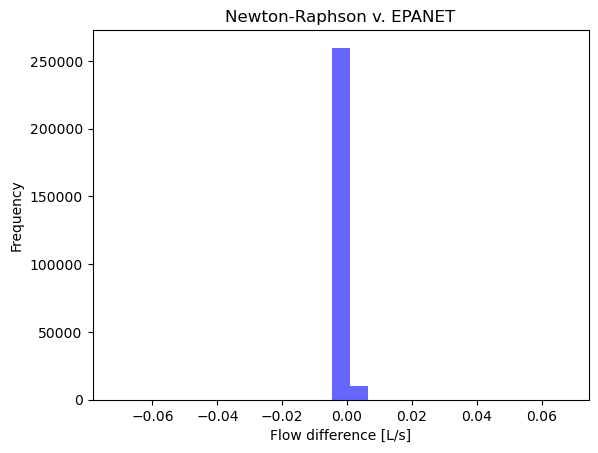

In [48]:
# Newton-Raphson v. EPANET: flow
qdiff_1 = q_nr.iloc[:, 1:] - q_epa.iloc[:, 1:]
qdiff_1_array = qdiff_1.values.flatten() * 1000
plt.hist(qdiff_1_array, bins = 25, color='blue', alpha=0.6)

# Set labels and title
plt.xlabel('Flow difference [L/s]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson v. EPANET')

# Display the plot
plt.show()

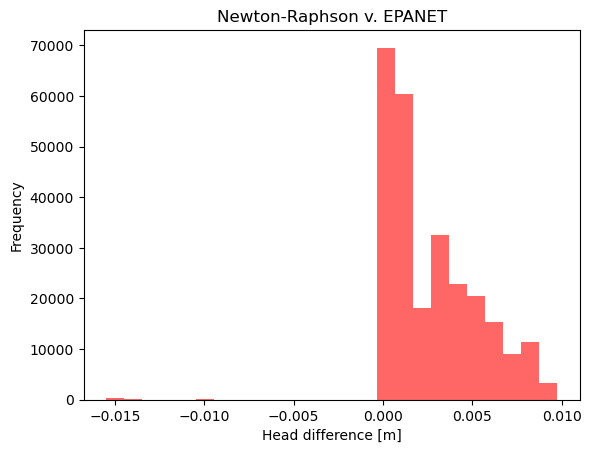

In [43]:
# Newton-Raphson v. EPANET: hydraulic head
hdiff_1 = h_nr.iloc[:, 1:] - h_epa.iloc[:, 1:]
hdiff_1_array = hdiff_1.values.flatten()
plt.hist(hdiff_1_array, bins = 25, color='red', alpha=0.6)

# Set labels and title
plt.xlabel('Head difference [m]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson v. EPANET')

# Display the plot
plt.show()

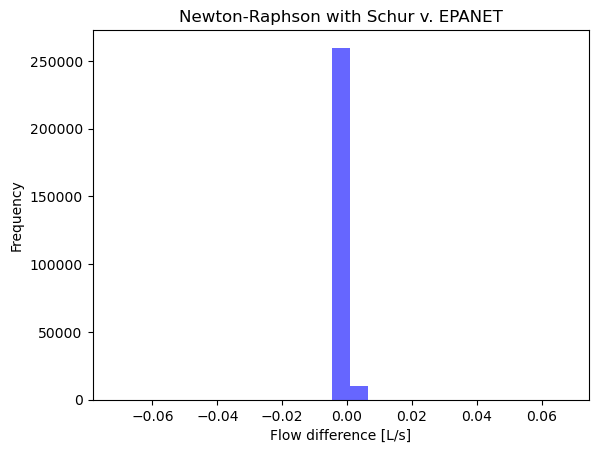

In [47]:
# Newton-Raphson with Schur v. EPANET: flow
qdiff_2 = q_schur.iloc[:, 1:] - q_epa.iloc[:, 1:]
qdiff_2_array = qdiff_2.values.flatten() *1000
plt.hist(qdiff_2_array, bins = 25, color='blue', alpha=0.6)

# Set labels and title
plt.xlabel('Flow difference [L/s]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson with Schur v. EPANET')

# Display the plot
plt.show()

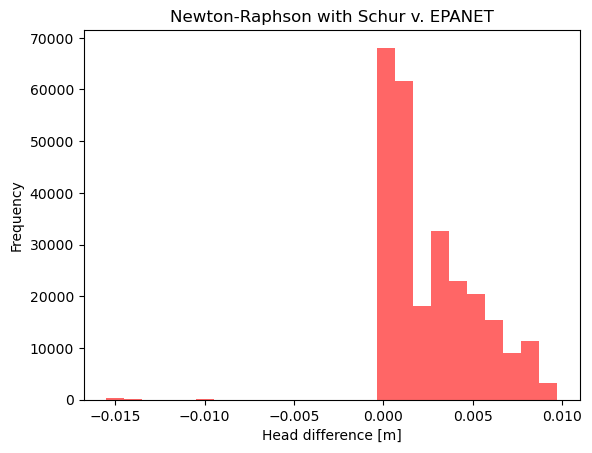

In [46]:
# Newton-Raphson with Schur v. EPANET: hydraulic head
hdiff_2 = h_schur.iloc[:, 1:] - h_epa.iloc[:, 1:]
hdiff_2_array = hdiff_2.values.flatten()
plt.hist(hdiff_2_array, bins = 25, color='red', alpha=0.6)

# Set labels and title
plt.xlabel('Head difference [m]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson with Schur v. EPANET')

# Display the plot
plt.show()

### Future work items

This notebook could be extended to include:
1. Tanks (or storage facilities with finite volume)
2. Hydraulic controls (e.g. pressure control valves, pumping)